# Notes

```
function ClickConnect(){
console.log("Working"); 
document.querySelector("colab-toolbar-button#connect").click() 
}
setInterval(ClickConnect,60000)
```

Scenario
- Various paging arrival rate
- Various beam number
- Various mobility (Static, low mobility, high mobility)

Baseline
- Sequential, each PO same resource number
- Fast paging, same resource number in average
- If beam training, consider the consumed resources
- Include an optimal scenario as upper bound (complete information)

Extend to general model for multiple BSs if possible

2019.11.26
- Find a better scenario for the proposal
- What metric is more suitable?
  - Hit probability
  - power saving
  - resource consumption
  - paging delay
- Implement the maximum paging number.

2019.12.03
- Consider power efficiency

2019.12.16
- Implement NR as the baseline
- Fit into the fast paging framework

# General definition

In [ ]:
import numpy as np
import pickle as pkl
import timeit
from heapdict import *

# ! pip install -q pymdptoolbox
# import mdptoolbox as mdp
# from collections import defaultdict

def generate_problem (ue_num, bs_beam_num):
  x = np.random.rand (ue_num, bs_beam_num)
  x /= x.sum(axis=1).reshape(ue_num, 1)
  k = np.random.randint (0, 10, size=ue_num)
  return x, k

def check_resource_per_beam_constraint (c, s):
  return all(c.sum(axis=0)<=s*resource_per_beam)

def check_paging_beam_constraint (s):
  return s.sum() <= paging_beam_limit

def get_utility (c, x, k):
  return -((1-c*x).prod(axis=1) * k).sum() - paging_resource_cost*c.sum()

def print_result(x, k, c, s, u):
  print ('x\n', x.round(2), '\nk\n', k, '\nc\n', c, '\ns\n', s, '\nu\n', u.round(2))

def print_tiktoc(t, number=1):
  print ('Time usage: {}s'.format(round((timeit.default_timer() - t)/number, 4)))

def get_s_from_c (c):
  s = c.sum(axis=0)
  s[ s>0 ] = 1
  return s

def get_cdf (x):
  x = np.sort(x)
  p = 1. * np.arange(len(x)) / (len(x) - 1)
  return {'x': x, 'p': p}


# Simulation patameters

In [ ]:
random_seed = int (timeit.default_timer())

ue_num = 100
bs_beam_num = 24

resource_per_beam = 16
paging_beam_limit = 8

paging_resource_cost = 1e-3

timeit_number = 50

simulation_time = 1000

paging_cycle = 10
paging_arrival_rate = 0.01
stay_probability = 0.9
estimated_stay_probability = 0.9

# Methods

## Brute force (branch and bound)

In [ ]:
def solve_problem_brute_kernel (x, k, c, s, h):
  c_opt, s_opt, u_opt = c.copy(), s.copy(), get_utility(c, x, k)
  for i in range(bs_beam_num):
    for j in range(ue_num):
      if c[j, i] == 1:
        continue
      c[j, i] = 1
      key = pkl.dumps(c)
      if key not in h:
        s = get_s_from_c (c)
        h[key] = check_resource_per_beam_constraint(c, s) and check_paging_beam_constraint(s)
        if h[key]:
          c_temp, s_temp, u_temp = solve_problem_brute_kernel (x, k, c, s, h)
          if u_temp > u_opt:
            c_opt, s_opt, u_opt = c_temp.copy(), s_temp.copy(), u_temp
      c[j, i] = 0
  return c_opt, s_opt, u_opt

def solve_problem_brute (x, k):
  c = np.zeros ((ue_num, bs_beam_num), dtype=np.int32)
  s = np.zeros ((bs_beam_num), dtype=np.int32)
  c, s, u = solve_problem_brute_kernel(x, k, c, s, {})
  return c, s, u

In [ ]:
np.random.seed (random_seed)

x, k = generate_problem ()
t = timeit.default_timer()
c, s, u = solve_problem_brute (x, k)

print_tiktoc(t)
print_result(x, k, c, s, -u)

## Estimate important beams

In [ ]:
def evaluate_priority_beam():
  cc = [(i//bs_beam_num, i%bs_beam_num) for i in (x * k.reshape(ue_num, 1)).reshape(bs_beam_num*ue_num).argsort()]
  ss = np.zeros(bs_beam_num)
  for i in range(len(cc)):
    ss[ cc[i][1] ] -= i
  return ss.argsort()

def solve_problem_beam_kernel(x, k, c, s, h):
  c_opt, u_opt = c.copy(), get_utility(c, x, k)
  for i in range(bs_beam_num):
    if s[i] == 0:
      continue
    for j in range(ue_num):
      if c[j, i] == 1:
        continue
      c[j, i] = 1
      key = pkl.dumps(c)
      if key not in h:
        h[key] = check_resource_per_beam_constraint(c, s)
        if h[key]:
          c_temp, u_temp = solve_problem_beam_kernel (x, k, c, s, h)
          if u_temp > u_opt:
            c_opt, u_opt = c_temp.copy(), u_temp
      c[j, i] = 0
  return c_opt, u_opt

def solve_problem_beam (x, k):
  c = np.zeros ((ue_num, bs_beam_num), dtype=np.int32)
  s = np.zeros ((bs_beam_num), dtype=np.int32)
  ss = evaluate_priority_beam()
  for i in range(paging_beam_limit):
    s[ ss[i] ] = 1
  c, u = solve_problem_beam_kernel(x, k, c, s, {})
  return c, s, u

In [ ]:
np.random.seed (random_seed)

x, k = generate_problem ()
t = timeit.default_timer()
c, s, u = solve_problem_beam (x, k)

print_tiktoc(t)
print_result(x, k, c, s, -u)

Time usage: 0.7454s
x
 [[0.21 0.13 0.08 0.04 0.19 0.03 0.18 0.12]
 [0.12 0.08 0.17 0.09 0.16 0.   0.18 0.21]
 [0.21 0.17 0.04 0.13 0.16 0.04 0.14 0.1 ]
 [0.1  0.01 0.07 0.14 0.15 0.11 0.27 0.16]
 [0.07 0.22 0.15 0.08 0.16 0.06 0.21 0.04]
 [0.21 0.12 0.15 0.17 0.06 0.06 0.06 0.18]
 [0.22 0.25 0.01 0.1  0.08 0.16 0.04 0.14]
 [0.18 0.01 0.15 0.23 0.18 0.21 0.   0.04]
 [0.14 0.14 0.12 0.16 0.11 0.1  0.15 0.09]
 [0.22 0.03 0.22 0.2  0.03 0.1  0.01 0.2 ]] 
k
 [8 0 2 6 6 2 2 3 3 7] 
c
 [[1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [1 0 0 1 0 0 0 0]] 
s
 [1 0 0 1 0 0 0 0] 
u
 33.87


## Estimate important UE

In [ ]:
def evaluate_priority_ue():
  (x * k.reshape(ue_num, 1)).reshape(bs_beam_num*ue_num)
  return [(i//bs_beam_num, i%bs_beam_num) for i in (x * k.reshape(ue_num, 1)).reshape(bs_beam_num*ue_num).argsort()][::-1]

def solve_problem_greedy (x, k):
  c = np.zeros ((ue_num, bs_beam_num), dtype=np.int32)
  s = np.zeros ((bs_beam_num), dtype=np.int32)
  cc = evaluate_priority_ue()
  for ue_id, beam_id in cc:
    if s[ beam_id ] == 0:
      s[ beam_id ] = 1
      if check_paging_beam_constraint(s) == False:
        s[ beam_id ] = 0
      else:
        c[ ue_id ][ beam_id ] = 1
    else:
      c[ ue_id ][ beam_id ] = 1
      if check_resource_per_beam_constraint(c, s) == False:
        c[ ue_id ][ beam_id ] = 0
  return c, s, get_utility(c, x, k)

In [ ]:
np.random.seed (random_seed)

x, k = generate_problem ()
t = timeit.default_timer()
for _ in range(timeit_number):
  c, s, u = solve_problem_greedy (x, k)

print_tiktoc(t, timeit_number)
print_result(x, k, c, s, -u)

Time usage: 0.0007s
x
 [[0.21 0.13 0.08 0.04 0.19 0.03 0.18 0.12]
 [0.12 0.08 0.17 0.09 0.16 0.   0.18 0.21]
 [0.21 0.17 0.04 0.13 0.16 0.04 0.14 0.1 ]
 [0.1  0.01 0.07 0.14 0.15 0.11 0.27 0.16]
 [0.07 0.22 0.15 0.08 0.16 0.06 0.21 0.04]
 [0.21 0.12 0.15 0.17 0.06 0.06 0.06 0.18]
 [0.22 0.25 0.01 0.1  0.08 0.16 0.04 0.14]
 [0.18 0.01 0.15 0.23 0.18 0.21 0.   0.04]
 [0.14 0.14 0.12 0.16 0.11 0.1  0.15 0.09]
 [0.22 0.03 0.22 0.2  0.03 0.1  0.01 0.2 ]] 
k
 [8 0 2 6 6 2 2 3 3 7] 
c
 [[1 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0]] 
s
 [1 0 0 0 0 0 1 0] 
u
 33.03


## Estimate important UE with updating priority

In [ ]:
def evaluate_priority_ue_heap():
  val = -(x * k.reshape(ue_num, 1)).reshape(bs_beam_num*ue_num)
  key = [(i//bs_beam_num, i%bs_beam_num) for i in range(bs_beam_num*ue_num)]
  return heapdict(zip(key, val))

def solve_problem_greedy_updating (x, k):
  c = np.zeros ((ue_num, bs_beam_num), dtype=np.int32)
  s = np.zeros ((bs_beam_num), dtype=np.int32)
  h = evaluate_priority_ue_heap()
  while len(h)>0:
    (ue_id, beam_id), val = h.popitem()
    if paging_resource_cost + val >= 0:
      break
    if s[ beam_id ] == 0:
      s[ beam_id ] = 1
      if check_paging_beam_constraint(s) == False:
        s[ beam_id ] = 0
      else:
        c[ ue_id ][ beam_id ] = 1
        for i in range(bs_beam_num):
          kk = (ue_id, i)
          if kk in h:
            h[kk] *= 1-x[ ue_id ][ beam_id ]
    else:
      c[ ue_id ][ beam_id ] = 1
      if check_resource_per_beam_constraint(c, s) == False:
        c[ ue_id ][ beam_id ] = 0
      else:
        for i in range(bs_beam_num):
          kk = (ue_id, i)
          if kk in h:
            h[kk] *= 1-x[ ue_id ][ beam_id ]
  return c, s, get_utility(c, x, k)

In [ ]:
np.random.seed (random_seed)

x, k = generate_problem ()
t = timeit.default_timer()
for _ in range(timeit_number):
  c, s, u = solve_problem_greedy_updating (x, k)

print_tiktoc(t, timeit_number)
print_result(x, k, c, s, -u)

Time usage: 0.0015s
x
 [[0.21 0.13 0.08 0.04 0.19 0.03 0.18 0.12]
 [0.12 0.08 0.17 0.09 0.16 0.   0.18 0.21]
 [0.21 0.17 0.04 0.13 0.16 0.04 0.14 0.1 ]
 [0.1  0.01 0.07 0.14 0.15 0.11 0.27 0.16]
 [0.07 0.22 0.15 0.08 0.16 0.06 0.21 0.04]
 [0.21 0.12 0.15 0.17 0.06 0.06 0.06 0.18]
 [0.22 0.25 0.01 0.1  0.08 0.16 0.04 0.14]
 [0.18 0.01 0.15 0.23 0.18 0.21 0.   0.04]
 [0.14 0.14 0.12 0.16 0.11 0.1  0.15 0.09]
 [0.22 0.03 0.22 0.2  0.03 0.1  0.01 0.2 ]] 
k
 [8 0 2 6 6 2 2 3 3 7] 
c
 [[1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0]] 
s
 [1 0 0 0 0 0 1 0] 
u
 32.9


# Batch run simulation


## Definition

In [ ]:
import numpy as np
class Parameter:
  def __init__(self):
    self.reset()

  def reset(self):
    self.label = 'Default'
    self.seed_setup = 0
    self.seed_run = 0
    self.ue_num = 10
    self.bs_beam_num = 8
    self.resource_per_beam = 2
    self.resource_per_beam_pattern = []
    self.paging_beam_limit = 2
    self.paging_beam_limit_pattern = []
    self.paging_resource_cost = 0
    self.timeit_number = 50
    self.paging_cycle = 1.28
    self.paging_arrival_rate = 1e-2
    self.stay_probability = np.zeros(self.ue_num) + 0.9
    self.estimated_stay_probability = np.zeros(self.ue_num) + 0.9
    self.update_all_UE_location_on_paged_beam = False
    self.update_all_UE_location_on_paged_beam_pattern = []
    self.method = 'Linear'
    self.max_paging_number = 16

  def set_stay_probability_from_time(self, t):
    self.stay_probability = np.zeros(self.ue_num) + (1-(self.bs_beam_num-1)*(1-np.exp(-self.paging_cycle/t))/self.bs_beam_num)

  def set_stay_probability(self, setting):
    percent_total = sum(setting.values())
    setting = {k:int(self.ue_num*setting[k]/percent_total) for k in setting}
    self.stay_probability = np.zeros(self.ue_num)
    n = 0
    for k in setting:
      self.stay_probability[n:] = 1-(self.bs_beam_num-1)*(1-np.exp(-self.paging_cycle/k))/self.bs_beam_num
      n += setting[k]
  
  def set_estimated_stay_probability(self, setting, stdev):
    percent_total = sum(setting.values())
    setting = {k:int(self.ue_num*setting[k]/percent_total) for k in setting}
    self.estimated_stay_probability = np.zeros(self.ue_num)
    n = 0
    for k in setting:
      self.estimated_stay_probability[n:] = 1-(self.bs_beam_num-1)*(1-np.exp(-self.paging_cycle/(k*abs(np.random.normal(1, stdev)))))/self.bs_beam_num
      n += setting[k]

class Tictoc:
  def __init__(self):
    self.reset()

  def reset(self):
    import timeit
    self.timer = timeit.default_timer()
    return self

  def print(self, number=1):
    import timeit
    self.result = round((timeit.default_timer() - self.timer)/number, 4)
    print ('Time usage: {}s'.format(self.result))
    return self

class CDF:
  def __init__(self, x):
    self.length = len(x)
    self.x = np.sort(x)
    self.p = np.arange(self.length, dtype=np.float64) / (self.length - 1)
  def plot(self, label=''):
    from matplotlib import pyplot as plt
    plt.plot(self.x, self.p, label=label)

class Simulator:
  def __init__(self, parameter):
    self.label = parameter.label
    self.seed_setup = parameter.seed_setup
    self.seed_run = parameter.seed_run
    self.ue_num = parameter.ue_num
    self.bs_beam_num = parameter.bs_beam_num
    self.resource_per_beam = parameter.resource_per_beam
    self.resource_per_beam_pattern = parameter.resource_per_beam_pattern
    self.paging_beam_limit = parameter.paging_beam_limit
    self.paging_beam_limit_pattern = parameter.paging_beam_limit_pattern
    self.paging_resource_cost = parameter.paging_resource_cost
    self.timeit_number = parameter.timeit_number
    self.paging_cycle = parameter.paging_cycle
    self.paging_arrival_rate = parameter.paging_arrival_rate
    self.stay_probability = parameter.stay_probability
    self.estimated_stay_probability = parameter.estimated_stay_probability
    self.update_all_UE_location_on_paged_beam = parameter.update_all_UE_location_on_paged_beam
    self.update_all_UE_location_on_paged_beam_pattern = parameter.update_all_UE_location_on_paged_beam_pattern
    self.method = parameter.method
    self.max_paging_number = parameter.max_paging_number
    self.tictoc = Tictoc()
    self.solver_list = {
        'Greedy with updating UE value': self.solve_problem_greedy_updating,
        'Greedy': self.solve_problem_greedy,
        'Greedy with beam sweeping': self.solve_problem_greedy_sweeping,
        'FIFO with beam sweeping': self.solve_problem_fifo_sweeping,
        'Linear': self.solve_problem_linear,
        'Linearx': self.solve_problem_linearx
    }

  def setup(self):
    np.random.seed(self.seed_setup)
    self.set_estimate_ue_beam_transfer_matrix()
    self.set_paging_arrival_probability()
    self.k = np.zeros(self.ue_num) # Instant paging delay
    self.set_ue_location()
    self.z = np.zeros(self.ue_num) # Indicate instant paging arrival
    self.c = np.zeros((self.ue_num, self.bs_beam_num)) # BS detailed paging decision (UE, Beam)
    self.s = np.zeros(self.bs_beam_num) # BS paging beam decision
    self.u = np.zeros(self.ue_num) # Instant serving cost (instant delay of successful paging and consumed resource number)
    self.f = np.zeros(self.ue_num) # Indicate of successful paging
    self.ps = np.zeros(self.ue_num) # Accumulation of successful paging
    self.pf = np.zeros(self.ue_num) # Accumulation of failed paging
    self.m = {}
    self.record()
    self.solve_bs_decision = self.solver_list[self.method]
    self.ss = list(range(self.bs_beam_num))
    return self

  def run(self, simulation_time=1000):
    np.random.seed(self.seed_run)
    self.tictoc.reset()
    for current_time in range(1, simulation_time):
      self.solve_bs_decision().perform_decision().update_paging_request().update_estimate_ue_beam_location().update_ue_beam_location().renew_resource_limit().record(current_time)
    self.tictoc.print()
    return self

  def getCDF_expected_system_utility(self):
    return CDF(np.array([((1-self.m[k]['c']*self.m[k]['x']).prod(axis=1) * (self.m[k]['k']+self.m[k]['u'])).sum() + self.paging_resource_cost*mm['c'].sum() for k in self.m]))

  def getCDF_system_utility(self):
    return CDF(np.array([self.m[k]['k'].sum() + self.paging_resource_cost*self.m[k]['c'].sum() for k in self.m]))

  def getCDF_system_paging_delay(self):
    return CDF(np.array([self.m[k]['u'].sum() for k in self.m]) * self.paging_cycle)

  def getCDF_paging_delay(self):
    x = np.concatenate([self.m[k]['u'] for k in self.m]) * self.paging_cycle
    return CDF(x[x>0])

  def get_paging_delay_of_UE(self, ue_id=0):
    if ue_id < self.ue_num:
      return [self.m[k]['u'][ue_id] for k in self.m] * self.paging_cycle

  def get_paging_hit_rate(self):
    return round(100*self.ps.sum()/(self.ps.sum()+self.pf.sum()), 6)

  def get_paging_delay(self):
    x = np.concatenate([self.m[k]['u'] for k in self.m]) * self.paging_cycle
    return round(x[x>0].mean(), 6)

  def get_expected_system_utility(self):
    return round(np.array([((1-self.m[k]['c']*self.m[k]['x']).prod(axis=1) * (self.m[k]['k']+self.m[k]['u'])).sum() + self.paging_resource_cost*self.m[k]['c'].sum() for k in self.m]).mean(), 6)
    
  def get_system_utility(self):
    return round(np.array([self.m[k]['k'].sum() + self.paging_resource_cost*self.m[k]['c'].sum() for k in self.m]).mean(), 6)

  def get_system_paging_delay(self):
    return round((np.array([self.m[k]['k'].sum() for k in self.m])*self.paging_cycle).mean(), 6)

  def get_throughput(self):
    return self.ps.sum()/(len(self.m)*self.paging_cycle)

  def get_tictoc_time(self):
    return self.tictoc.result

  def record(self, timestamp=0):
    self.m[timestamp] = {'k':self.k.copy(), 'u':self.u.copy()}
    return self
    
  def record_detail(self, timestamp=0):
    self.m[timestamp] = {'k':self.k.copy(), 'x':self.x.copy(), 'xx':self.xx.copy(), 'u':self.u.copy(), 'z':self.z.copy(), 'c':self.c.copy(), 's':self.s.copy(), 'f':self.f.copy()}
    return self

  def set_ue_location(self):
    self.x = np.zeros((self.ue_num, self.bs_beam_num)) # Estimated UE location distribution probability
    self.xx = np.random.randint(0, self.bs_beam_num, size=self.ue_num) # Exact UE instant location
    for i in range(self.ue_num):
      self.x[ i, self.xx[i] ] = 1 # Initialize UE location

  def set_paging_arrival_probability(self):
    self.paging_arrival_probability = 1-np.exp(-self.paging_arrival_rate*self.paging_cycle) # Paging arriving probability in every paging occasion

  def set_estimate_ue_beam_transfer_matrix(self):
    self.transfer_matrix = {}
    for i in self.estimated_stay_probability:
      if i not in self.transfer_matrix:
        transfer_matrix = np.zeros((self.bs_beam_num, self.bs_beam_num)) + (1-i)/(self.bs_beam_num-1)
        for j in range(self.bs_beam_num): transfer_matrix[j, j] = i
        self.transfer_matrix[i] = transfer_matrix

  def update_paging_request(self):
    self.z = np.random.binomial(1, self.paging_arrival_probability, size=self.ue_num)
    self.k[self.k>0] += 1
    self.pf[self.k > self.max_paging_number] += 1
    self.k[self.k > self.max_paging_number] = 0
    self.k[self.k==0] = self.z[self.k==0]
    return self

  def update_estimate_ue_beam_location(self):
    self.x[self.f, :] = 0
    for i in [j for j in range(self.ue_num) if self.f[j]]: self.x[i, self.xx[i]] = 1
    if self.update_all_UE_location_on_paged_beam:
      xi = [i for i in range(self.ue_num) if self.s[self.xx[i]]]
      self.x[xi, :] = 0
      for i in xi:  self.x[i, self.xx[i]] = 1
    d = self.c.any(axis=1) & ~self.f
    for i in [j for j in range(self.ue_num) if d[j]]:
      self.x[i, ~self.c[i, :]] += self.x[i, self.c[i, :]].sum()/(~self.c[i, :]).sum()
      self.x[i, self.c[i, :]] = 0
    for estimated_stay_probability, transfer_matrix in self.transfer_matrix.items():
      i = self.estimated_stay_probability==estimated_stay_probability
      self.x[i, :] = np.dot(self.x[i, :], transfer_matrix)
    return self

  def update_ue_beam_location(self):
    new_beam_location = np.random.randint(0, self.bs_beam_num-2, size=self.ue_num)
    new_beam_location += (new_beam_location>=self.xx)
    stay = np.random.rand(self.ue_num) <= self.stay_probability
    self.xx[~stay] = new_beam_location[~stay]
    return self

  def renew_resource_limit(self):
    if self.paging_beam_limit_pattern:
      self.paging_beam_limit = self.paging_beam_limit_pattern.pop(0)
      self.paging_beam_limit_pattern.append(self.paging_beam_limit)
    if self.resource_per_beam_pattern:
      self.resource_per_beam = self.resource_per_beam_pattern.pop(0)
      self.resource_per_beam_pattern.append(self.resource_per_beam)
    if self.update_all_UE_location_on_paged_beam_pattern:
      self.update_all_UE_location_on_paged_beam = self.update_all_UE_location_on_paged_beam_pattern.pop(0)
      self.update_all_UE_location_on_paged_beam_pattern.append(self.update_all_UE_location_on_paged_beam)
    return self

  def perform_decision(self):
    self.f = np.zeros(self.ue_num, dtype=np.bool)
    for i in range(self.ue_num): self.f[i] = self.c[i, self.xx[i]]   # UE i is paged on beam xx[i], where xx[i] is the location of UE i
    self.ps[self.f] += 1
    self.u = np.zeros(self.ue_num)
    self.u[self.f] = self.k[self.f]
    self.k[self.f] = 0
    return self

  def solve_problem_greedy_updating(self):
    from heapdict import heapdict
    self.c, self.s = np.zeros ((self.ue_num, self.bs_beam_num), dtype=np.bool), np.zeros ((self.bs_beam_num), dtype=np.bool)
    h = dict(zip([(i//self.bs_beam_num, i%self.bs_beam_num) for i in range(self.bs_beam_num*self.ue_num)], self.paging_resource_cost-(self.x * self.k.reshape(self.ue_num, 1)).reshape(self.bs_beam_num*self.ue_num)))
    h = heapdict({key:h[key] for key in h if h[key] < 0})
    while len(h)>0:
      (ue_id, beam_id), val = h.popitem()
      if val >= 0: break
      if ~self.s[beam_id]:
        if self.s.sum() < self.paging_beam_limit: self.s[beam_id] = True
        else: continue
      if self.c[:, beam_id].sum() < self.resource_per_beam:
        self.c[ue_id, beam_id] = True
        for kk in [(ue_id, i) for i in range(self.bs_beam_num) if (ue_id, i) in h]: h[kk] *= 1-self.x[ue_id, beam_id]
    return self

  def solve_problem_greedy(self):
    cc = (self.x * self.k.reshape(self.ue_num, 1)) - self.paging_resource_cost
    uid = cc.reshape(self.bs_beam_num*self.ue_num).argsort()[::-1]
    for beam_id in uid%self.bs_beam_num:
      self.s[beam_id] = True
      if self.s.sum()==self.paging_beam_limit: break
    for ue_id, beam_id in zip(uid//self.bs_beam_num, uid%self.bs_beam_num):
      if self.cc[ue_id, beam_id]==0: break
      if self.s[beam_id]:
        if self.c[:,beam_id].sum() < self.resource_per_beam: self.c[ue_id,beam_id] = True
        else: self.s[beam_id] = False
    self.s = self.c.any(axis=0)
    return self

  def solve_problem_greedy_sweeping(self):
    self.c, self.s = np.zeros ((self.ue_num, self.bs_beam_num), dtype=np.bool), np.zeros ((self.bs_beam_num), dtype=np.bool)
    self.s[self.ss[:self.paging_beam_limit]] = True
    self.ss = self.ss[self.paging_beam_limit:] + self.ss[:self.paging_beam_limit]
    cc = self.x * self.k.reshape(self.ue_num, 1) - self.paging_resource_cost
    for b in range(self.bs_beam_num):
      if self.s[b]:
        ue_id = [ue_id for ue_id in cc[:, b].argsort()[::-1][:self.resource_per_beam] if cc[ue_id, b] > 0]
        self.c[ue_id, b] = 1
    return self

  def solve_problem_fifo_sweeping(self):
    self.c, self.s = np.zeros ((self.ue_num, self.bs_beam_num), dtype=np.bool), np.zeros ((self.bs_beam_num), dtype=np.bool)
    self.s[self.ss[:self.paging_beam_limit]] = True
    self.ss = self.ss[self.paging_beam_limit:] + self.ss[:self.paging_beam_limit]
    self.c[self.k.argsort()[::-1][:self.resource_per_beam], :] = True
    self.c[:, ~self.s] = False
    self.c[self.k==0,:] = False
    return self

  def solve_problem_linear(self):
    self.c, self.s, bss = np.zeros ((self.ue_num, self.bs_beam_num), dtype=np.bool), np.zeros ((self.bs_beam_num), dtype=np.bool), np.zeros (self.bs_beam_num)
    cc = self.x * self.k.reshape(self.ue_num, 1) - self.paging_resource_cost
    for b in range(self.bs_beam_num):
      ue_id = [ue_id for ue_id in cc[:, b].argsort()[::-1][:self.resource_per_beam] if cc[ue_id, b] > 0]
      bss[b], self.c[ue_id, b] = cc[ue_id, b].sum(), True
    self.s[ [ beam_id for beam_id in bss.argsort()[::-1][:self.paging_beam_limit ] if bss[beam_id]>0 ] ] = True
    self.c[:, ~self.s] = False
    return self

  def solve_problem_linearx(self):
    self.c, self.s, bss = np.zeros ((self.ue_num, self.bs_beam_num), dtype=np.bool), np.zeros ((self.bs_beam_num), dtype=np.bool), np.zeros (self.bs_beam_num)
    cc = -np.log(1+1e-9-self.x) * self.k.reshape(self.ue_num, 1) - self.paging_resource_cost
    for b in range(self.bs_beam_num):
      ue_id = [ue_id for ue_id in cc[:, b].argsort()[::-1][:self.resource_per_beam] if cc[ue_id, b] > 0]
      bss[b], self.c[ue_id, b] = cc[ue_id, b].sum(), True
    self.s[ [ beam_id for beam_id in bss.argsort()[::-1][:self.paging_beam_limit ] if bss[beam_id]>0 ] ] = True
    self.c[:, ~self.s] = False
    return self

  def update_s_from_c(self):
    import numpy as np
    self.s = np.array(self.c.sum(axis=0), dtype=np.bool)

def mount_drive():
  from google.colab import drive
  drive.mount('/content/drive')

def save_result(fname, result):
  import pickle, gzip, datetime
  with gzip.open('/content/drive/Shared drives/sakl-cc/paging/{}_{}.pickle.gz'.format(datetime.datetime.now().strftime("%Y%m%d_%H%M"), fname), 'wb') as fout:
    pickle.dump(result, fout)

def load_result(fname):
  import pickle, gzip
  with gzip.open('/content/drive/Shared drives/sakl-cc/paging/{}.pickle.gz'.format(fname), 'rb') as fin:
    result = pickle.load(fin)
  return result

def parallel_run(tasks):
  import multiprocessing
  p = multiprocessing.Pool()
  return p.map(run_simulator_wrapper, tasks)

def current_time():
  import datetime
  import pytz
  tz = pytz.timezone('Asia/Taipei')
  return str(datetime.datetime.now(tz))

def download_plot(filename):
  from google.colab import files
  from matplotlib import rc
  rc('pdf', fonttype=42)
  plt.tight_layout()
  plt.savefig(filename+'.pdf')
  files.download(filename+'.pdf')

## Shell script
Paging cycle in Spec
- 32 radio frames
- 64 radio frames
- 128 radio frames
- 256 radio frames

Resource per beam in Spec [maxPageRec, maxNrofPageRec]
- 16 (LTE value)
- 32 (NR value)

Paging Attempt Count and the Intended Number of Paging Attempts

### Experiment 1: Paging arrival rate

In [ ]:
mount_drive()
#===============================================================================
paging_arrival_rate = np.arange(0.01, 0.11, 0.01)
paramList = []

param = Parameter()
param.label = 'Fast paging only'
param.paging_arrival_rate = 0.05
param.bs_beam_num = 24
param.ue_num = 1000
param.paging_cycle = 0.32
param.paging_beam_limit = 6
param.max_paging_number = 12
param.resource_per_beam = 32
param.set_stay_probability({1.28:1})
param.estimated_stay_probability = param.stay_probability
param.update_all_UE_location_on_paged_beam = False
param.method = 'Linearx'
paramList.append(param)

param = Parameter()
param.label = 'Full paging only'
param.paging_arrival_rate = 0.05
param.bs_beam_num = 24
param.ue_num = 1000
param.paging_cycle = 1.28
param.paging_beam_limit = 24
param.max_paging_number = 3
param.resource_per_beam = 32
param.set_stay_probability({1.28:1})
param.estimated_stay_probability = param.stay_probability
param.update_all_UE_location_on_paged_beam = False
param.method = 'Linearx'
paramList.append(param)

param = Parameter()
param.label = 'Fast paging (NR setting)'
param.paging_arrival_rate = 0.05
param.bs_beam_num = 24
param.ue_num = 1000
param.paging_cycle = 0.32
param.paging_beam_limit = 6
param.max_paging_number = 12
param.resource_per_beam = 32
param.set_stay_probability({1.28:1})
param.estimated_stay_probability = param.stay_probability
param.update_all_UE_location_on_paged_beam = False
param.method = 'FIFO with beam sweeping'
paramList.append(param)

param = Parameter()
param.label = 'Full paging (NR setting)'
param.paging_arrival_rate = 0.05
param.bs_beam_num = 24
param.ue_num = 1000
param.paging_cycle = 1.28
param.paging_beam_limit = 24
param.max_paging_number = 3
param.resource_per_beam = 32
param.set_stay_probability({1.28:1})
param.estimated_stay_probability = param.stay_probability
param.update_all_UE_location_on_paged_beam = False
param.method = 'FIFO with beam sweeping'
paramList.append(param)

param = Parameter()
param.label = 'FF paging'
param.paging_arrival_rate = 0.05
param.bs_beam_num = 24
param.ue_num = 1000
param.paging_cycle = 0.32
param.paging_beam_limit_pattern = [15, 3, 3, 3]
param.max_paging_number = 12
param.resource_per_beam = 32
param.set_stay_probability({1.28:1})
param.estimated_stay_probability = param.stay_probability
param.update_all_UE_location_on_paged_beam = False
param.method = 'Linearx'
paramList.append(param)

param = Parameter()
param.label = 'FF paging (Locate all UEs in Full)'
param.paging_arrival_rate = 0.05
param.bs_beam_num = 24
param.ue_num = 1000
param.paging_cycle = 0.32
param.paging_beam_limit_pattern = [15, 3, 3, 3]
param.max_paging_number = 12
param.resource_per_beam = 32
param.set_stay_probability({1.28:1})
param.estimated_stay_probability = param.stay_probability
param.update_all_UE_location_on_paged_beam_pattern = [True, False, False, False]
param.method = 'Linearx'
paramList.append(param)

param = Parameter()
param.label = 'FF paging (FIFO)'
param.paging_arrival_rate = 0.05
param.bs_beam_num = 24
param.ue_num = 1000
param.paging_cycle = 0.32
param.paging_beam_limit_pattern = [15, 3, 3, 3]
param.max_paging_number = 12
param.resource_per_beam = 32
param.set_stay_probability({1.28:1})
param.estimated_stay_probability = param.stay_probability
param.update_all_UE_location_on_paged_beam = False
param.method = 'FIFO with beam sweeping'
paramList.append(param)

print(current_time())
def run_simulator_wrapper(simulator):
    return simulator.run(5000)
tasks = []
for p in paramList:
  for a in paging_arrival_rate:
    p.paging_arrival_rate = a
    tasks.append(Simulator(p).setup())
result = parallel_run(tasks)
print(current_time())

save_result('Exp1', result)
save_result('Exp1_paramList', {'paramList':paramList, 'paging_arrival_rate':paging_arrival_rate})

Mounted at /content/drive
2021-06-16 15:13:13.650207+08:00
Time usage: 114.8317s
Time usage: 117.4761s
Time usage: 141.9632s
Time usage: 149.6981s
Time usage: 117.8046s
Time usage: 117.8046s
Time usage: 124.5322s
Time usage: 124.5322s
Time usage: 144.8436s
Time usage: 144.8436s
Time usage: 153.2568s
Time usage: 153.2568s
Time usage: 135.061s
Time usage: 135.061s
Time usage: 129.2619s
Time usage: 129.2619s
Time usage: 141.1003s
Time usage: 141.1003s
Time usage: 148.3172s
Time usage: 148.3172s
Time usage: 132.0148s
Time usage: 132.0148s
Time usage: 133.9546s
Time usage: 133.9546s
Time usage: 144.4628s
Time usage: 144.4628s
Time usage: 150.5642s
Time usage: 150.5642s
Time usage: 136.4428s
Time usage: 136.4428s
Time usage: 135.0475s
Time usage: 135.0475s
Time usage: 50.5257s
Time usage: 50.5257s
Time usage: 62.6054s
Time usage: 62.6054s
Time usage: 140.9662s
Time usage: 140.9662s
Time usage: 145.2111s
Time usage: 145.2111s
Time usage: 52.1143s
Time usage: 52.1143s
Time usage: 45.7332s
Time

### Experiment 2: UE Number

In [ ]:
mount_drive()
#===============================================================================
ue_num = np.arange(200, 1100, 100)
paramList = []

param = Parameter()
param.label = 'Fast paging only'
param.paging_arrival_rate = 0.05
param.bs_beam_num = 24
param.ue_num = 500
param.paging_cycle = 0.32
param.paging_beam_limit = 6
param.max_paging_number = 12
param.resource_per_beam = 16
param.update_all_UE_location_on_paged_beam = False
param.method = 'Greedy with updating UE value'
paramList.append(param)

param = Parameter()
param.label = 'Full paging only'
param.paging_arrival_rate = 0.05
param.bs_beam_num = 24
param.ue_num = 500
param.paging_cycle = 1.28
param.paging_beam_limit = 24
param.max_paging_number = 3
param.resource_per_beam = 16
param.update_all_UE_location_on_paged_beam = False
param.method = 'Greedy with updating UE value'
paramList.append(param)

param = Parameter()
param.label = 'Fast paging (NR setting)'
param.paging_arrival_rate = 0.05
param.bs_beam_num = 24
param.ue_num = 500
param.paging_cycle = 0.32
param.paging_beam_limit = 6
param.max_paging_number = 12
param.resource_per_beam = 16
param.update_all_UE_location_on_paged_beam = False
param.method = 'FIFO with beam sweeping'
paramList.append(param)

param = Parameter()
param.label = 'Full paging (NR setting)'
param.paging_arrival_rate = 0.05
param.bs_beam_num = 24
param.ue_num = 500
param.paging_cycle = 1.28
param.paging_beam_limit = 24
param.max_paging_number = 3
param.resource_per_beam = 16
param.update_all_UE_location_on_paged_beam = False
param.method = 'FIFO with beam sweeping'
paramList.append(param)

param = Parameter()
param.label = 'FF paging'
param.paging_arrival_rate = 0.05
param.bs_beam_num = 24
param.ue_num = 500
param.paging_cycle = 0.32
param.paging_beam_limit_pattern = [15, 3, 3, 3]
param.max_paging_number = 12
param.resource_per_beam = 16
param.update_all_UE_location_on_paged_beam = False
param.method = 'Greedy with updating UE value'
paramList.append(param)

param = Parameter()
param.label = 'FF paging (Locate all UEs in Full)'
param.paging_arrival_rate = 0.05
param.bs_beam_num = 24
param.ue_num = 500
param.paging_cycle = 0.32
param.paging_beam_limit_pattern = [15, 3, 3, 3]
param.max_paging_number = 12
param.resource_per_beam = 16
param.update_all_UE_location_on_paged_beam_pattern = [True, False, False, False]
param.method = 'Greedy with updating UE value'
paramList.append(param)

param = Parameter()
param.label = 'FF paging (FIFO)'
param.paging_arrival_rate = 0.05
param.bs_beam_num = 24
param.ue_num = 500
param.paging_cycle = 0.32
param.paging_beam_limit_pattern = [15, 3, 3, 3]
param.max_paging_number = 12
param.resource_per_beam = 16
param.update_all_UE_location_on_paged_beam = False
param.method = 'FIFO with beam sweeping'
paramList.append(param)

print(current_time())
def run_simulator_wrapper(simulator):
    return simulator.run(5000)
tasks = []
for p in paramList:
  for a in ue_num:
    p.ue_num = a
    p.set_stay_probability({1.28:1})
    p.estimated_stay_probability = param.stay_probability
    tasks.append(Simulator(p).setup())
result = parallel_run(tasks)
print(current_time())

save_result('Exp2', result)
save_result('Exp2_paramList', {'paramList':paramList, 'ue_num':ue_num})

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
2020-02-14 10:53:54.266171+08:00
Time usage: 603.5328s
Time usage: 1004.9026s
Time usage: 1904.8196s
Time usage: 2531.4381s
Time usage: 1366.7235s
Time usage: 1932.376s
Time usage: 1716.4285s
Time usage: 1636.54s
Time usage: 5239.4417s
Time usage: 1926.5671s
Time usage: 2643.9703s
Time usage: 1764.3528s
Time usage: 223.9237s
Time usage: 575.0677s
Time usage: 709.2654s
Time usage: 4504.0809s
Time usage: 5222.5703s
Time usage: 829.6863s
Time usage: 3539.1039s
Time usage: 998.9607s
Time usage: 786.7537s
Time usage: 1101.8022s
Time usage: 1162.0431s
Time usage: 1249.5255s
Time usage: 158.2334s
Time usage: 3788.957s
Time usage: 1674.7686s
Time usage: 4305.3621s
Time usage: 35.3746s
Time usage: 65.1513s
Time usage: 310.2004s
Time usage: 531.1157s
Time usage: 796.5238s
Time usage: 2690.3476s
Time usage: 2080.5788s
Time usage: 1134.3278s
Time usage: 3657.0701s
Time u

### Experiment 3: Paging cycle

In [ ]:
mount_drive()
#===============================================================================
paging_cycle = np.arange(0.16, 2.6, 0.32)
paramList = []

param = Parameter()
param.label = 'Fast paging only'
param.paging_arrival_rate = 0.05
param.bs_beam_num = 24
param.ue_num = 500
param.paging_cycle = 0.32
param.paging_beam_limit = 6
param.max_paging_number = 12
param.resource_per_beam = 16
param.update_all_UE_location_on_paged_beam = False
param.method = 'Greedy with updating UE value'
paramList.append(param)

param = Parameter()
param.label = 'Full paging only'
param.paging_arrival_rate = 0.05
param.bs_beam_num = 24
param.ue_num = 500
param.paging_cycle = 0.32
param.paging_beam_limit_pattern = [24, 0, 0, 0]
param.max_paging_number = 12
param.resource_per_beam = 16
param.update_all_UE_location_on_paged_beam = False
param.method = 'Greedy with updating UE value'
paramList.append(param)

param = Parameter()
param.label = 'Fast paging (NR setting)'
param.paging_arrival_rate = 0.05
param.bs_beam_num = 24
param.ue_num = 500
param.paging_cycle = 0.32
param.paging_beam_limit = 6
param.max_paging_number = 12
param.resource_per_beam = 16
param.update_all_UE_location_on_paged_beam = False
param.method = 'FIFO with beam sweeping'
paramList.append(param)

param = Parameter()
param.label = 'Full paging (NR setting)'
param.paging_arrival_rate = 0.05
param.bs_beam_num = 24
param.ue_num = 500
param.paging_cycle = 0.32
param.paging_beam_limit_pattern = [24, 0, 0, 0]
param.max_paging_number = 12
param.resource_per_beam = 16
param.update_all_UE_location_on_paged_beam = False
param.method = 'FIFO with beam sweeping'
paramList.append(param)

param = Parameter()
param.label = 'FF paging'
param.paging_arrival_rate = 0.05
param.bs_beam_num = 24
param.ue_num = 500
param.paging_cycle = 0.32
param.paging_beam_limit_pattern = [12, 4, 4, 4]
param.max_paging_number = 12
param.resource_per_beam = 16
param.update_all_UE_location_on_paged_beam = False
param.method = 'Greedy with updating UE value'
paramList.append(param)

param = Parameter()
param.label = 'FF paging (Locate all UEs in Full)'
param.paging_arrival_rate = 0.05
param.bs_beam_num = 24
param.ue_num = 500
param.paging_cycle = 0.32
param.paging_beam_limit_pattern = [12, 4, 4, 4]
param.max_paging_number = 12
param.resource_per_beam = 16
param.update_all_UE_location_on_paged_beam_pattern = [True, False, False, False]
param.method = 'Greedy with updating UE value'
paramList.append(param)

param = Parameter()
param.label = 'FF paging (FIFO)'
param.paging_arrival_rate = 0.05
param.bs_beam_num = 24
param.ue_num = 500
param.paging_cycle = 0.32
param.paging_beam_limit_pattern = [12, 4, 4, 4]
param.max_paging_number = 12
param.resource_per_beam = 16
param.update_all_UE_location_on_paged_beam = False
param.method = 'FIFO with beam sweeping'
paramList.append(param)

print(current_time())
def run_simulator_wrapper(simulator):
    return simulator.run(5000)
tasks = []
for p in paramList:
  for a in paging_cycle:
    p.paging_cycle = a
    p.set_stay_probability({1.28:1})
    p.estimated_stay_probability = p.stay_probability
    tasks.append(Simulator(p).setup())
result = parallel_run(tasks)
print(current_time())

save_result('Exp3', result)
save_result('Exp3_paramList', {'paramList':paramList, 'paging_cycle':paging_cycle})

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
2020-01-08 09:19:46.503670+08:00
Time usage: 652.6836s
Time usage: 718.1783s
Time usage: 1370.0302s
Time usage: 1452.312s
Time usage: 1078.5661s
Time usage: 111.9378s
Time usage: 1184.3404s
Time usage: 378.8849s
Time usage: 151.9681s
Time usage: 810.0729s
Time usage: 476.0734s
Time usage: 1657.0597s
Time usage: 1694.103s
Time usage: 782.1722s
Time usage: 713.0481s
Time usage: 1074.0561s
Time usage: 626.8498s
Time usage: 1481.1135s
Time usage: 1168.3836s
Time usage: 1243.3625s
Time usage: 121.487s
Time usage: 406.093s
Time usage: 1099.178s
Time usage: 577.9837s
Time usage: 1350.9742s
Time usage: 1554.1455s
Time usage: 651.8758s
Time usage: 855.6745s
2020-01-08 11:16:38.350813+08:00


### Experiment 4: Two mobility

In [ ]:
mount_drive()
#===============================================================================
paging_arrival_rate = np.arange(0.01, 0.1, 0.01)

paramList = []
param = Parameter()
param.label = 'Fast paging only'
param.paging_arrival_rate = 0.05
param.bs_beam_num = 24
param.ue_num = 500
param.paging_cycle = 0.32
param.paging_beam_limit = 6
param.max_paging_number = 12
param.resource_per_beam = 20
param.set_stay_probability({0.32:1, 1.28:1})
param.estimated_stay_probability = param.stay_probability
param.update_all_UE_location_on_paged_beam = False
param.method = 'Greedy with updating UE value'
paramList.append(param)

param = Parameter()
param.label = 'Full paging only'
param.paging_arrival_rate = 0.05
param.bs_beam_num = 24
param.ue_num = 500
param.paging_cycle = 1.28
param.paging_beam_limit = 24
param.max_paging_number = 3
param.resource_per_beam = 20
param.set_stay_probability({0.32:1, 1.28:1})
param.estimated_stay_probability = param.stay_probability
param.update_all_UE_location_on_paged_beam = False
param.method = 'Greedy with updating UE value'
paramList.append(param)

param = Parameter()
param.label = 'Fast paging (NR setting)'
param.paging_arrival_rate = 0.05
param.bs_beam_num = 24
param.ue_num = 500
param.paging_cycle = 0.32
param.paging_beam_limit = 6
param.max_paging_number = 12
param.resource_per_beam = 20
param.set_stay_probability({0.32:1, 1.28:1})
param.estimated_stay_probability = param.stay_probability
param.update_all_UE_location_on_paged_beam = False
param.method = 'FIFO with beam sweeping'
paramList.append(param)

param = Parameter()
param.label = 'Full paging (NR setting)'
param.paging_arrival_rate = 0.05
param.bs_beam_num = 24
param.ue_num = 500
param.paging_cycle = 1.28
param.paging_beam_limit = 24
param.max_paging_number = 3
param.resource_per_beam = 20
param.set_stay_probability({0.32:1, 1.28:1})
param.estimated_stay_probability = param.stay_probability
param.update_all_UE_location_on_paged_beam = False
param.method = 'FIFO with beam sweeping'
paramList.append(param)

param = Parameter()
param.label = 'FF paging'
param.paging_arrival_rate = 0.05
param.bs_beam_num = 24
param.ue_num = 500
param.paging_cycle = 0.32
param.paging_beam_limit_pattern = [15, 3, 3, 3]
param.max_paging_number = 12
param.resource_per_beam = 20
param.set_stay_probability({0.32:1, 1.28:1})
param.estimated_stay_probability = param.stay_probability
param.update_all_UE_location_on_paged_beam = False
param.method = 'Greedy with updating UE value'
paramList.append(param)

param = Parameter()
param.label = 'FF paging (Locate all UEs in Full)'
param.paging_arrival_rate = 0.05
param.bs_beam_num = 24
param.ue_num = 500
param.paging_cycle = 0.32
param.paging_beam_limit_pattern = [15, 3, 3, 3]
param.max_paging_number = 12
param.resource_per_beam = 20
param.set_stay_probability({0.32:1, 1.28:1})
param.estimated_stay_probability = param.stay_probability
param.update_all_UE_location_on_paged_beam_pattern = [True, False, False, False]
param.method = 'Greedy with updating UE value'
paramList.append(param)

param = Parameter()
param.label = 'FF paging (FIFO)'
param.paging_arrival_rate = 0.05
param.bs_beam_num = 24
param.ue_num = 500
param.paging_cycle = 0.32
param.paging_beam_limit_pattern = [15, 3, 3, 3]
param.max_paging_number = 12
param.resource_per_beam = 20
param.set_stay_probability({0.32:1, 1.28:1})
param.estimated_stay_probability = param.stay_probability
param.update_all_UE_location_on_paged_beam = False
param.method = 'FIFO with beam sweeping'
paramList.append(param)

print(current_time())
def run_simulator_wrapper(simulator):
    return simulator.run(5000)
tasks = []
for p in paramList:
  for a in paging_arrival_rate:
    p.paging_arrival_rate = a
    tasks.append(Simulator(p).setup())
result = parallel_run(tasks)
print(current_time())

save_result('Exp4', result)
save_result('Exp4_paramList', {'paramList':paramList, 'paging_arrival_rate':paging_arrival_rate})

### Experiment 5: Fast paging beam per cycle

In [ ]:
mount_drive()
#===============================================================================
paging_beam_limit = np.arange(2, 25, 2)

paramList = []
param = Parameter()
param.label = 'Fast paging only'
param.paging_arrival_rate = 0.05
param.bs_beam_num = 24
param.ue_num = 500
param.paging_cycle = 0.32
param.paging_beam_limit = 6
param.max_paging_number = 12
param.resource_per_beam = 20
param.set_stay_probability({0.32:1, 1.28:1})
param.estimated_stay_probability = param.stay_probability
param.update_all_UE_location_on_paged_beam = False
param.method = 'Greedy with updating UE value'
paramList.append(param)

param = Parameter()
param.label = 'Fast paging (NR setting)'
param.paging_arrival_rate = 0.05
param.bs_beam_num = 24
param.ue_num = 500
param.paging_cycle = 0.32
param.paging_beam_limit = 6
param.max_paging_number = 12
param.resource_per_beam = 20
param.set_stay_probability({0.32:1, 1.28:1})
param.estimated_stay_probability = param.stay_probability
param.update_all_UE_location_on_paged_beam = False
param.method = 'FIFO with beam sweeping'
paramList.append(param)

param = Parameter()
param.label = 'FF paging'
param.paging_arrival_rate = 0.05
param.bs_beam_num = 24
param.ue_num = 500
param.paging_cycle = 0.32
param.paging_beam_limit_pattern = [24, 4, 4, 4]
param.max_paging_number = 12
param.resource_per_beam = 20
param.set_stay_probability({0.32:1, 1.28:1})
param.estimated_stay_probability = param.stay_probability
param.update_all_UE_location_on_paged_beam = False
param.method = 'Greedy with updating UE value'
paramList.append(param)

param = Parameter()
param.label = 'FF paging (Locate all UEs in Full)'
param.paging_arrival_rate = 0.05
param.bs_beam_num = 24
param.ue_num = 500
param.paging_cycle = 0.32
param.paging_beam_limit_pattern = [24, 4, 4, 4]
param.max_paging_number = 12
param.resource_per_beam = 20
param.set_stay_probability({0.32:1, 1.28:1})
param.estimated_stay_probability = param.stay_probability
param.update_all_UE_location_on_paged_beam_pattern = [True, False, False, False]
param.method = 'Greedy with updating UE value'
paramList.append(param)

param = Parameter()
param.label = 'FF paging (FIFO)'
param.paging_arrival_rate = 0.05
param.bs_beam_num = 24
param.ue_num = 500
param.paging_cycle = 0.32
param.paging_beam_limit_pattern = [24, 4, 4, 4]
param.max_paging_number = 12
param.resource_per_beam = 20
param.set_stay_probability({0.32:1, 1.28:1})
param.estimated_stay_probability = param.stay_probability
param.update_all_UE_location_on_paged_beam = False
param.method = 'FIFO with beam sweeping'
paramList.append(param)
#===============================================================================
print(current_time())
def run_simulator_wrapper(simulator):
    return simulator.run(5000)
tasks = []
for p in paramList:
  for a in paging_beam_limit:
    if 'FF paging' in p.label:
      p.paging_beam_limit_pattern = [24, a, a, a]
    else:
      p.paging_beam_limit = a
    tasks.append(Simulator(p).setup())
result = parallel_run(tasks)
print(current_time())
#===============================================================================
save_result('Exp5', result)
save_result('Exp5_paramList', {'paramList':paramList, 'paging_beam_limit':paging_beam_limit})

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
2020-01-08 18:01:23.403552+08:00
Time usage: 65.5013s
Time usage: 138.6378s
Time usage: 184.7901s
Time usage: 419.9306s
Time usage: 102.0832s
Time usage: 538.0537s
Time usage: 577.7676s
Time usage: 96.1306s
Time usage: 100.1862s
Time usage: 99.4565s
Time usage: 103.9173s
Time usage: 554.8765s
Time usage: 107.6831s
Time usage: 531.8243s
Time usage: 110.1944s
Time usage: 558.4483s
Time usage: 110.7559s
Time usage: 112.6749s
Time usage: 521.5897s
Time usage: 669.2156s
Time usage: 555.2294s
Time usage: 507.1409s
Time usage: 782.2135s
Time usage: 555.7953s
Time usage: 624.8222s
Time usage: 566.3577s
Time usage: 534.0865s
Time usage: 669.6678s
Time usage: 605.5254s
Time usage: 546.0416s
Time usage: 526.3442s
Time usage: 619.3943s
Time usage: 651.0655s
Time usage: 541.64s
Time usage: 518.7366s
Time usage: 588.122s
Time usage: 590.1264s
Time usage: 535.6972s
Time usa

### Experiment 6: Number of fast paging in FF paging

In [ ]:
mount_drive()
#===============================================================================
ff_number = np.arange(0, 16, 1)

paramList = []
param = Parameter()
param.label = 'FF paging'
param.paging_arrival_rate = 0.05
param.bs_beam_num = 24
param.ue_num = 500
param.paging_cycle = 0.32
param.paging_beam_limit_pattern = [24, 4, 4, 4]
param.max_paging_number = 12
param.resource_per_beam = 20
param.set_stay_probability({0.32:1, 1.28:1})
param.estimated_stay_probability = param.stay_probability
param.update_all_UE_location_on_paged_beam = False
param.method = 'Greedy with updating UE value'
paramList.append(param)

param = Parameter()
param.label = 'FF paging (Locate all UEs in Full)'
param.paging_arrival_rate = 0.05
param.bs_beam_num = 24
param.ue_num = 500
param.paging_cycle = 0.32
param.paging_beam_limit_pattern = [24, 4, 4, 4]
param.max_paging_number = 12
param.resource_per_beam = 20
param.set_stay_probability({0.32:1, 1.28:1})
param.estimated_stay_probability = param.stay_probability
param.update_all_UE_location_on_paged_beam_pattern = [True, False, False, False]
param.method = 'Greedy with updating UE value'
paramList.append(param)

param = Parameter()
param.label = 'FF paging (FIFO)'
param.paging_arrival_rate = 0.05
param.bs_beam_num = 24
param.ue_num = 500
param.paging_cycle = 0.32
param.paging_beam_limit_pattern = [24, 4, 4, 4]
param.max_paging_number = 12
param.resource_per_beam = 20
param.set_stay_probability({0.32:1, 1.28:1})
param.estimated_stay_probability = param.stay_probability
param.update_all_UE_location_on_paged_beam = False
param.method = 'FIFO with beam sweeping'
paramList.append(param)
#===============================================================================
print(current_time())
def run_simulator_wrapper(simulator):
    return simulator.run(10000)
tasks = []
for p in paramList:
  for a in ff_number:
    p.paging_beam_limit_pattern = [24]
    for b in range(a):
      p.paging_beam_limit_pattern.append(4)
    tasks.append(Simulator(p).setup())
result = parallel_run(tasks)
print(current_time())
#===============================================================================
save_result('Exp6', result)
save_result('Exp6_paramList', {'paramList':paramList, 'ff_number':ff_number})

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
2020-01-09 15:09:28.442847+08:00
Time usage: 839.9805s
Time usage: 1074.3291s
Time usage: 1105.5026s
Time usage: 1174.4375s
Time usage: 912.2639s
Time usage: 1084.2539s
Time usage: 1149.2522s
Time usage: 1148.5133s
Time usage: 993.9995s
Time usage: 1069.5897s
Time usage: 1190.0138s
Time usage: 1127.6533s
Time usage: 1060.7729s
Time usage: 1030.0651s
Time usage: 910.6378s
Time usage: 1030.602s
Time usage: 1048.3212s
Time usage: 857.1905s
Time usage: 1030.9178s
Time usage: 1087.7305s
Time usage: 1035.5243s
Time usage: 894.3565s
Time usage: 1038.8631s
Time usage: 1130.2708s
Time usage: 187.7511s
Time usage: 1083.0934s
Time usage: 1016.0262s
Time usage: 204.5387s
Time usage: 284.5151s
Time usage: 1012.8891s
Time usage: 400.2621s
Time usage: 1062.2208s
Time usage: 1031.5991s
Time usage: 398.4592s
Time usage: 1010.0066s
Time usage: 388.5575s
Time usage: 191.3954s
T

### Experiment 7: Imperfect estimation of stay time

In [ ]:
mount_drive()
#===============================================================================
estimated_stay_time = np.arange(0.32, 2.6, 0.32)
paramList = []

param = Parameter()
param.label = 'Fast paging only'
param.paging_arrival_rate = 0.04
param.bs_beam_num = 24
param.ue_num = 500
param.paging_cycle = 0.32
param.paging_beam_limit = 6
param.max_paging_number = 12
param.resource_per_beam = 16
param.set_stay_probability({0.64:1})
param.update_all_UE_location_on_paged_beam = False
param.method = 'Greedy with updating UE value'
paramList.append(param)

param = Parameter()
param.label = 'Full paging only'
param.paging_arrival_rate = 0.04
param.bs_beam_num = 24
param.ue_num = 500
param.paging_cycle = 1.28
param.paging_beam_limit = 24
param.max_paging_number = 3
param.resource_per_beam = 16
param.set_stay_probability({0.64:1})
param.update_all_UE_location_on_paged_beam = False
param.method = 'Greedy with updating UE value'
paramList.append(param)

param = Parameter()
param.label = 'Fast paging (NR setting)'
param.paging_arrival_rate = 0.04
param.bs_beam_num = 24
param.ue_num = 500
param.paging_cycle = 0.32
param.paging_beam_limit = 6
param.max_paging_number = 12
param.resource_per_beam = 16
param.set_stay_probability({0.64:1})
param.update_all_UE_location_on_paged_beam = False
param.method = 'FIFO with beam sweeping'
paramList.append(param)

param = Parameter()
param.label = 'Full paging (NR setting)'
param.paging_arrival_rate = 0.04
param.bs_beam_num = 24
param.ue_num = 500
param.paging_cycle = 1.28
param.paging_beam_limit = 24
param.max_paging_number = 3
param.resource_per_beam = 16
param.set_stay_probability({0.64:1})
param.update_all_UE_location_on_paged_beam = False
param.method = 'FIFO with beam sweeping'
paramList.append(param)

param = Parameter()
param.label = 'FF paging'
param.paging_arrival_rate = 0.04
param.bs_beam_num = 24
param.ue_num = 500
param.paging_cycle = 0.32
param.paging_beam_limit_pattern = [15, 3, 3, 3]
param.max_paging_number = 12
param.resource_per_beam = 16
param.set_stay_probability({0.64:1})
param.update_all_UE_location_on_paged_beam = False
param.method = 'Greedy with updating UE value'
paramList.append(param)

param = Parameter()
param.label = 'FF paging (Locate all UEs in Full)'
param.paging_arrival_rate = 0.04
param.bs_beam_num = 24
param.ue_num = 500
param.paging_cycle = 0.32
param.paging_beam_limit_pattern = [15, 3, 3, 3]
param.max_paging_number = 12
param.resource_per_beam = 16
param.set_stay_probability({0.64:1})
param.update_all_UE_location_on_paged_beam_pattern = [True, False, False, False]
param.method = 'Greedy with updating UE value'
paramList.append(param)

param = Parameter()
param.label = 'FF paging (FIFO)'
param.paging_arrival_rate = 0.04
param.bs_beam_num = 24
param.ue_num = 500
param.paging_cycle = 0.32
param.paging_beam_limit_pattern = [15, 3, 3, 3]
param.max_paging_number = 12
param.resource_per_beam = 16
param.set_stay_probability({0.64:1})
param.update_all_UE_location_on_paged_beam = False
param.method = 'FIFO with beam sweeping'
paramList.append(param)

print(current_time())
def run_simulator_wrapper(simulator):
    return simulator.run(5000)
tasks = []
for p in paramList:
  for a in estimated_stay_time:
    p.set_estimated_stay_probability({a:1}, 0.001)
    tasks.append(Simulator(p).setup())
result = parallel_run(tasks)
print(current_time())

save_result('Exp7', result)
save_result('Exp7_paramList', {'paramList':paramList, 'estimated_stay_time':estimated_stay_time})

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
2020-02-10 14:20:29.822377+08:00
Time usage: 1032.4884s
Time usage: 1039.6205s
Time usage: 887.9739s
Time usage: 920.7941s
Time usage: 2569.8864s
Time usage: 2599.1209s
Time usage: 892.7931s
Time usage: 913.4214s
Time usage: 896.769s
Time usage: 918.9282s
Time usage: 347.3168s
Time usage: 326.4349s
Time usage: 215.4602s
Time usage: 202.8437s
Time usage: 202.1732s
Time usage: 202.9854s
Time usage: 2046.1824s
Time usage: 2038.8754s
Time usage: 202.3474s
Time usage: 201.6058s
Time usage: 731.2905s
Time usage: 728.5796s
Time usage: 1376.5887s
Time usage: 1376.0926s
Time usage: 727.2044s
Time usage: 727.0323s
Time usage: 728.4633s
Time usage: 730.2482s
Time usage: 1377.3338s
Time usage: 1374.4646s
Time usage: 734.9751s
Time usage: 735.3601s
Time usage: 521.8704s
Time usage: 529.9075s
Time usage: 486.0894s
Time usage: 483.6975s
Time usage: 531.7317s
Time usage: 535

### Experiment 8: Mobility

In [ ]:
mount_drive()
#===============================================================================
beam_stay_time = np.arange(0.16, 3.8, 0.32)
paramList = []
paging_arrival_rate_value = 0.02

param = Parameter()
param.label = 'Fast paging only'
param.paging_arrival_rate = paging_arrival_rate_value
param.bs_beam_num = 24
param.ue_num = 1000
param.paging_cycle = 0.32
param.paging_beam_limit = 6
param.max_paging_number = 12
param.resource_per_beam = 32
param.update_all_UE_location_on_paged_beam = False
param.method = 'Linearx'
paramList.append(param)

param = Parameter()
param.label = 'Full paging only'
param.paging_arrival_rate = paging_arrival_rate_value
param.bs_beam_num = 24
param.ue_num = 1000
param.paging_cycle = 1.28
param.paging_beam_limit = 24
param.max_paging_number = 3
param.resource_per_beam = 32
param.update_all_UE_location_on_paged_beam = False
param.method = 'Linearx'
paramList.append(param)

if 0:
  param = Parameter()
  param.label = 'Fast paging (NR setting)'
  param.paging_arrival_rate = paging_arrival_rate_value
  param.bs_beam_num = 24
  param.ue_num = 1000
  param.paging_cycle = 0.32
  param.paging_beam_limit = 6
  param.max_paging_number = 12
  param.resource_per_beam = 32
  param.update_all_UE_location_on_paged_beam = False
  param.method = 'FIFO with beam sweeping'
  paramList.append(param)

param = Parameter()
param.label = 'Full paging (NR setting)'
param.paging_arrival_rate = paging_arrival_rate_value
param.bs_beam_num = 24
param.ue_num = 1000
param.paging_cycle = 1.28
param.paging_beam_limit = 24
param.max_paging_number = 3
param.resource_per_beam = 32
param.update_all_UE_location_on_paged_beam = False
param.method = 'FIFO with beam sweeping'
paramList.append(param)

param = Parameter()
param.label = 'FF paging'
param.paging_arrival_rate = paging_arrival_rate_value
param.bs_beam_num = 24
param.ue_num = 1000
param.paging_cycle = 0.32
param.paging_beam_limit_pattern = [15, 3, 3, 3]
param.max_paging_number = 12
param.resource_per_beam = 32
param.update_all_UE_location_on_paged_beam = False
param.method = 'Linearx'
paramList.append(param)

if 0:
  param = Parameter()
  param.label = 'FF paging (Locate all UEs in Full)'
  param.paging_arrival_rate = paging_arrival_rate_value
  param.bs_beam_num = 24
  param.ue_num = 1000
  param.paging_cycle = 0.32
  param.paging_beam_limit_pattern = [15, 3, 3, 3]
  param.max_paging_number = 12
  param.resource_per_beam = 32
  param.update_all_UE_location_on_paged_beam_pattern = [True, False, False, False]
  param.method = 'Linear'
  paramList.append(param)

if 0:
  param = Parameter()
  param.label = 'FF paging (FIFO)'
  param.paging_arrival_rate = paging_arrival_rate_value
  param.bs_beam_num = 24
  param.ue_num = 1000
  param.paging_cycle = 0.32
  param.paging_beam_limit_pattern = [15, 3, 3, 3]
  param.max_paging_number = 12
  param.resource_per_beam = 32
  param.update_all_UE_location_on_paged_beam = False
  param.method = 'FIFO with beam sweeping'
  paramList.append(param)

print(current_time())
def run_simulator_wrapper(simulator):
    return simulator.run(5000)
tasks = []
for p in paramList:
  for a in beam_stay_time:
    p.set_stay_probability({a:1})
    p.estimated_stay_probability = p.stay_probability
    tasks.append(Simulator(p).setup())
result = parallel_run(tasks)
print(current_time())

save_result('Exp8_'+str(paging_arrival_rate_value)+'_', result)
save_result('Exp8_'+str(paging_arrival_rate_value)+'_paramList', {'paramList':paramList, 'beam_stay_time':beam_stay_time})

Mounted at /content/drive
2021-06-16 17:24:57.517358+08:00
Time usage: 124.5668s
Time usage: 126.0981s
Time usage: 126.5667s
Time usage: 130.6244s
Time usage: 123.5573s
Time usage: 124.3227s
Time usage: 125.0897s
Time usage: 127.5478s
Time usage: 126.3698s
Time usage: 126.1938s
Time usage: 125.8726s
Time usage: 125.1292s
Time usage: 121.785s
Time usage: 122.2214s
Time usage: 122.7033s
Time usage: 122.8952s
Time usage: 121.7299s
Time usage: 122.4684s
Time usage: 122.2344s
Time usage: 122.3257s
Time usage: 119.751s
Time usage: 119.5807s
Time usage: 117.9466s
Time usage: 116.5564s
Time usage: 48.4475s
Time usage: 48.2345s
Time usage: 48.3429s
Time usage: 48.4521s
Time usage: 46.4773s
Time usage: 46.6298s
Time usage: 47.3574s
Time usage: 46.5172s
Time usage: 47.5351s
Time usage: 46.7084s
Time usage: 46.2031s
Time usage: 44.3879s
Time usage: 123.8931s
Time usage: 126.6527s
Time usage: 125.2802s
Time usage: 124.7885s
Time usage: 126.3108s
Time usage: 128.1479s
Time usage: 126.6819s
Time usag

### Experiment: Markov

In [ ]:
mount_drive()
#===============================================================================
paging_arrival_rate = np.arange(0.01, 0.11, 0.01)
paramList = []

param = Parameter()
param.label = 'Fast paging only'
param.paging_arrival_rate = 5e-2
param.bs_beam_num = 6
param.ue_num = 4
param.paging_cycle = 1.28
param.paging_beam_limit = 2
param.max_paging_number = 2
param.resource_per_beam = 2
param.set_stay_probability({0.64:1})
param.estimated_stay_probability = param.stay_probability
param.update_all_UE_location_on_paged_beam = False
param.method = 'Linearx'
paramList.append(param)

print(current_time())
def run_simulator_wrapper(simulator):
    return simulator.run(100000)
tasks = []
for p in paramList:
  for a in paging_arrival_rate:
    p.paging_arrival_rate = a
    tasks.append(Simulator(p).setup())
result = parallel_run(tasks)
print(current_time())

save_result('ExpM', result)
save_result('ExpM_paramList', {'paramList':paramList, 'paging_arrival_rate':paging_arrival_rate})
print ([result[i].get_system_paging_delay() for i in range(len(result))])

Mounted at /content/drive
2021-06-18 21:41:38.386481+08:00
Time usage: 44.2176s
Time usage: 44.3033s
Time usage: 44.5007s
Time usage: 44.7183s
Time usage: 44.2876s
Time usage: 45.0302s
Time usage: 45.2225s
Time usage: 45.7603s
Time usage: 27.78s
Time usage: 27.3651s
2021-06-18 21:43:40.922599+08:00
[0.161638, 0.31785, 0.464525, 0.604723, 0.74048, 0.872307, 1.001536, 1.118656, 1.243648, 1.367526]


In [ ]:
mount_drive()
#===============================================================================
paging_arrival_rate = np.arange(0.01, 0.11, 0.01)
paramList = []

param = Parameter()
param.label = 'Fast paging only'
param.paging_arrival_rate = 5e-2
param.bs_beam_num = 6
param.ue_num = 4
param.paging_cycle = 1.28
param.paging_beam_limit = 2
param.max_paging_number = 3
param.resource_per_beam = 2
param.set_stay_probability({0.64:1})
param.estimated_stay_probability = param.stay_probability
param.update_all_UE_location_on_paged_beam = False
param.method = 'Linearx'
paramList.append(param)

print(current_time())
def run_simulator_wrapper(simulator):
    return simulator.run(100000)
tasks = []
for p in paramList:
  for a in paging_arrival_rate:
    p.paging_arrival_rate = a
    tasks.append(Simulator(p).setup())
result = parallel_run(tasks)
print(current_time())

save_result('ExpM', result)
save_result('ExpM_paramList', {'paramList':paramList, 'paging_arrival_rate':paging_arrival_rate})
print ([result[i].get_system_paging_delay() for i in range(len(result))])

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
2021-06-18 21:44:40.867671+08:00
Time usage: 46.7494s
Time usage: 46.8977s
Time usage: 46.9033s
Time usage: 47.1179s
Time usage: 46.5455s
Time usage: 46.5996s
Time usage: 47.3857s
Time usage: 46.926s
Time usage: 28.7689s
Time usage: 29.2416s
2021-06-18 21:46:50.501468+08:00
[0.249869, 0.492851, 0.723802, 0.942067, 1.156352, 1.361395, 1.557171, 1.729485, 1.922637, 2.098906]


In [ ]:
mount_drive()
#===============================================================================
paging_arrival_rate = np.arange(0.01, 0.11, 0.01)
paramList = []

param = Parameter()
param.label = 'Fast paging only'
param.paging_arrival_rate = 5e-2
param.bs_beam_num = 6
param.ue_num = 4
param.paging_cycle = 1.28
param.paging_beam_limit = 2
param.max_paging_number = 4
param.resource_per_beam = 2
param.set_stay_probability({0.64:1})
param.estimated_stay_probability = param.stay_probability
param.update_all_UE_location_on_paged_beam = False
param.method = 'Linearx'
paramList.append(param)

print(current_time())
def run_simulator_wrapper(simulator):
    return simulator.run(100000)
tasks = []
for p in paramList:
  for a in paging_arrival_rate:
    p.paging_arrival_rate = a
    tasks.append(Simulator(p).setup())
result = parallel_run(tasks)
print(current_time())

save_result('ExpM', result)
save_result('ExpM_paramList', {'paramList':paramList, 'paging_arrival_rate':paging_arrival_rate})
print ([result[i].get_system_paging_delay() for i in range(len(result))])

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
2021-06-18 21:47:50.680104+08:00
Time usage: 46.5024s
Time usage: 46.8269s
Time usage: 46.8911s
Time usage: 46.9071s
Time usage: 46.233s
Time usage: 46.4211s
Time usage: 46.2359s
Time usage: 47.0083s
Time usage: 28.7948s
Time usage: 28.9392s
2021-06-18 21:49:59.722478+08:00
[0.315456, 0.618432, 0.911808, 1.187136, 1.458675, 1.713152, 1.960243, 2.184858, 2.426714, 2.656282]


## Result

### Experiment 1

In [ ]:
mount_drive()

if 0:
  result = load_result('20200212_1116_Exp1')
  label = load_result('20200212_1121_Exp1_paramList')

if 0:
  result = load_result('20200629_0315_Exp1')
  label = load_result('20200629_0319_Exp1_paramList')

if 0:
  result = load_result('20200722_0900_Exp1')
  label = load_result('20200722_0909_Exp1_paramList')

if 1:
  result = load_result('20210616_0743_Exp1')
  label = load_result('20210616_0751_Exp1_paramList')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

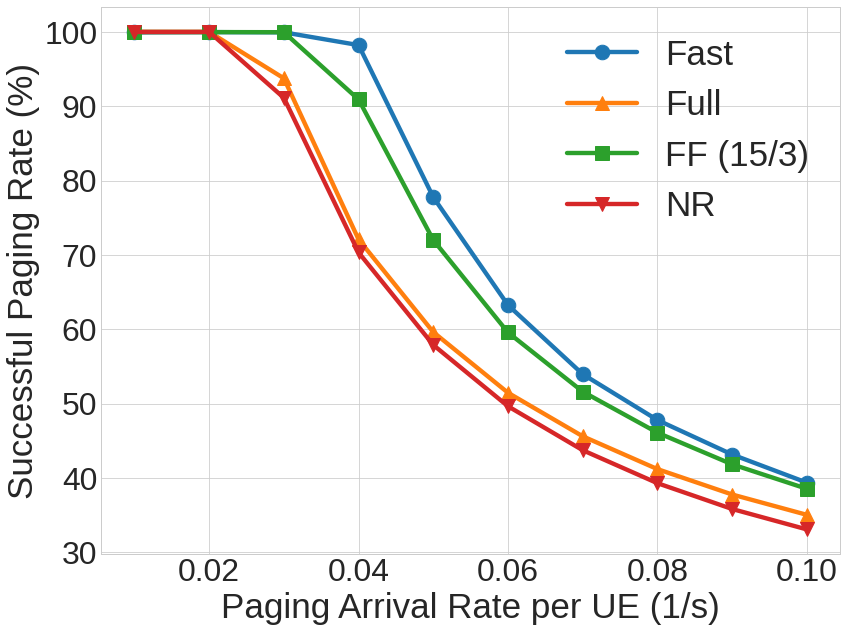

In [ ]:
from matplotlib import pyplot as plt
from matplotlib import rcParams
import numpy as np

fsize=35

rcParams.update({'font.size': 14})
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(12,9))

def plot_line(ll, ln='', ss='-'):
  x = label['paging_arrival_rate']
  if ln=='':
    ln=ll
  plt.plot(x, [s.get_paging_hit_rate() for s in result if s.label==ll], ss, label=ln, linewidth=fsize/8, markersize=fsize/2.4)

plot_line('Fast paging only', 'Fast', '-o')
plot_line('Full paging only', 'Full', '-^')
plot_line('FF paging', 'FF (15/3)', '-s')
#plot_line('Fast paging (NR setting)')
plot_line('Full paging (NR setting)', 'NR', '-v')
#plot_line('FF paging (Locate all UEs in Full)')
#plot_line('FF paging (FIFO)')

plt.xlabel('Paging Arrival Rate per UE (1/s)', fontsize=fsize)
plt.ylabel('Successful Paging Rate (%)', fontsize=fsize)
plt.xticks(fontsize=fsize/1.1)
plt.yticks(fontsize=fsize/1.1)
plt.legend(fontsize=fsize);

download_plot('arri_rate_succ_rate')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

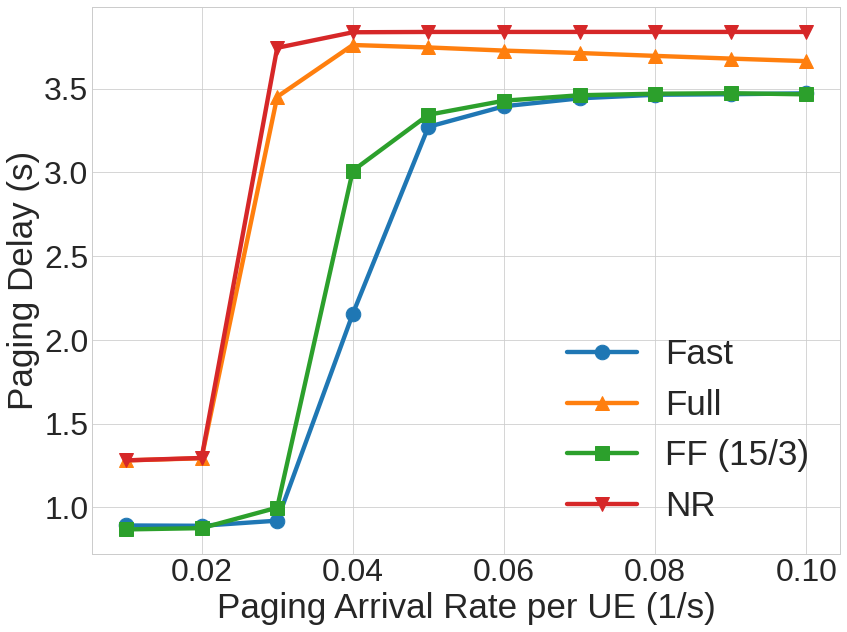

In [ ]:
from matplotlib import pyplot as plt
from matplotlib import rcParams
import numpy as np

fsize=35

rcParams.update({'font.size': 14})
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(12,9))

def plot_line(ll, ln='', ss='-'):
  x = label['paging_arrival_rate']
  if ln=='':
    ln = ll
  plt.plot(x, [s.get_paging_delay() for s in result if s.label==ll], ss, label=ln, linewidth=fsize/8, markersize=fsize/2.4)

plot_line('Fast paging only', 'Fast', '-o')
plot_line('Full paging only', 'Full', '-^')
plot_line('FF paging', 'FF (15/3)', '-s')
#plot_line('Fast paging (NR setting)')
plot_line('Full paging (NR setting)', 'NR', '-v')
#plot_line('FF paging (Locate all UEs in Full)')
#plot_line('FF paging (FIFO)')

plt.xlabel('Paging Arrival Rate per UE (1/s)', fontsize=fsize)
plt.ylabel('Paging Delay (s)', fontsize=fsize)
plt.xticks(fontsize=fsize/1.1)
plt.yticks(fontsize=fsize/1.1)
plt.legend(fontsize=fsize);

download_plot('arri_rate_delay')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

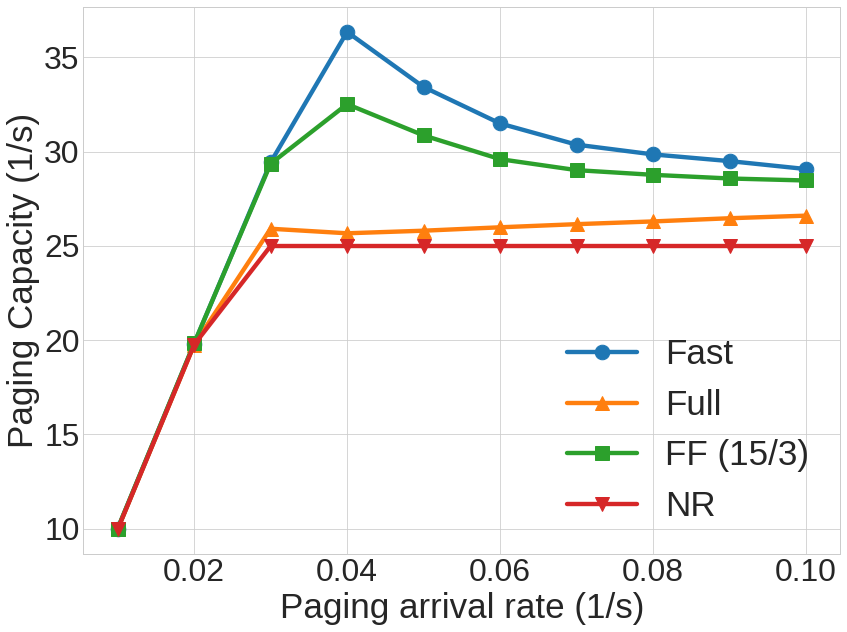

In [ ]:
from matplotlib import pyplot as plt
from matplotlib import rcParams
import numpy as np

fsize = 35

rcParams.update({'font.size': 14})
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(12,9))

def plot_line(ll, ln='', ss='-'):
  x = label['paging_arrival_rate']
  if ln=='':
    ln = ll
  plt.plot(x, [s.get_throughput() for s in result if s.label==ll], ss, label=ln, linewidth=fsize/8, markersize=fsize/2.4)

plot_line('Fast paging only', 'Fast', '-o')
plot_line('Full paging only', 'Full', '-^')
plot_line('FF paging', 'FF (15/3)', '-s')
#plot_line('Fast paging (NR setting)')
plot_line('Full paging (NR setting)', 'NR', '-v')
#plot_line('FF paging (Locate all UEs in Full)')
#plot_line('FF paging (FIFO)')

plt.xlabel('Paging arrival rate (1/s)', fontsize=fsize)
plt.ylabel('Paging Capacity (1/s)', fontsize=fsize)
plt.xticks(fontsize=fsize/1.1)
plt.yticks(fontsize=fsize/1.1)
plt.legend(fontsize=fsize);

download_plot('arri_rate_capacity')

### Experiment 2

In [ ]:
mount_drive()
result = load_result('20200214_1010_Exp2')
label = load_result('20200214_1014_Exp2_paramList')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


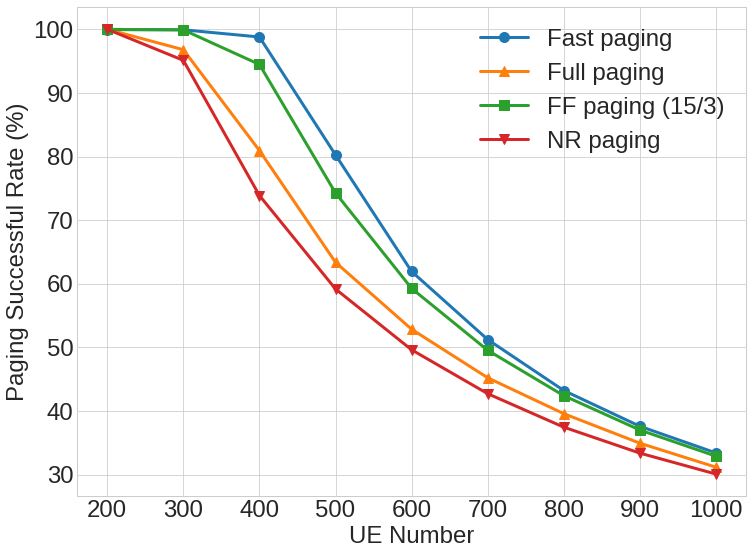

In [ ]:
from matplotlib import pyplot as plt
from matplotlib import rcParams
import numpy as np

rcParams.update({'font.size': 14})
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(12,9))

def plot_line(ll, ln='', ss='-'):
  x = label['ue_num']
  if ln=='':
    ln=ll
  plt.plot(x, [s.get_paging_hit_rate() for s in result if s.label==ll], ss, label=ln, linewidth=3, markersize=10)

plot_line('Fast paging only', 'Fast paging', '-o')
plot_line('Full paging only', 'Full paging', '-^')
plot_line('FF paging', 'FF paging (15/3)', '-s')
#plot_line('Fast paging (NR setting)')
plot_line('Full paging (NR setting)', 'NR paging', '-v')
#plot_line('FF paging (Locate all UEs in Full)')
#plot_line('FF paging (FIFO)')

plt.xlabel('UE Number', fontsize=24)
plt.ylabel('Successful Paging Rate (%)', fontsize=24)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(fontsize=24);

download_plot('UE_succ_rate')

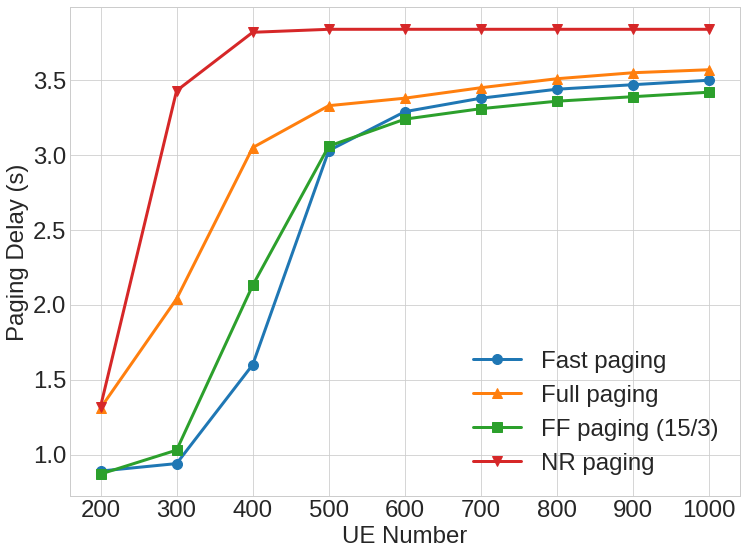

In [ ]:
from matplotlib import pyplot as plt
from matplotlib import rcParams
import numpy as np

rcParams.update({'font.size': 14})
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(12,9))

def plot_line(ll, ln='', ss='-'):
  x = label['ue_num']
  if ln=='':
    ln=ll
  plt.plot(x, [s.get_paging_delay() for s in result if s.label==ll], ss, label=ln, linewidth=3, markersize=10)

plot_line('Fast paging only', 'Fast paging', '-o')
plot_line('Full paging only', 'Full paging', '-^')
plot_line('FF paging', 'FF paging (15/3)', '-s')
#plot_line('Fast paging (NR setting)')
plot_line('Full paging (NR setting)', 'NR paging', '-v')
#plot_line('FF paging (Locate all UEs in Full)')
#plot_line('FF paging (FIFO)')

plt.xlabel('UE Number', fontsize=24)
plt.ylabel('Paging Delay (s)', fontsize=24)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(fontsize=24);

download_plot('UE_delay')

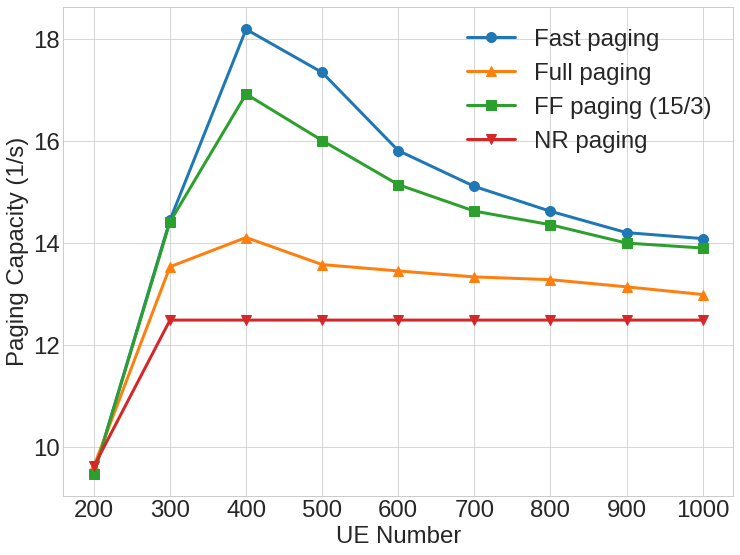

In [ ]:
from matplotlib import pyplot as plt
from matplotlib import rcParams
import numpy as np

rcParams.update({'font.size': 14})
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(12,9))

def plot_line(ll, ln='', ss='-'):
  x = label['ue_num']
  if ln=='':
    ln=ll
  plt.plot(x, [s.get_throughput() for s in result if s.label==ll], ss, label=ln, linewidth=3, markersize=10)

plot_line('Fast paging only', 'Fast paging', '-o')
plot_line('Full paging only', 'Full paging', '-^')
plot_line('FF paging', 'FF paging (15/3)', '-s')
#plot_line('Fast paging (NR setting)')
plot_line('Full paging (NR setting)', 'NR paging', '-v')
#plot_line('FF paging (Locate all UEs in Full)')
#plot_line('FF paging (FIFO)')

plt.xlabel('UE Number', fontsize=24)
plt.ylabel('Paging Capacity (1/s)', fontsize=24)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(fontsize=24);

download_plot('UE_capacity')

### Experiment 3

In [ ]:
mount_drive()
result = load_result('20200108_0316_Exp3')
label = load_result('20200108_0318_Exp3_paramList')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


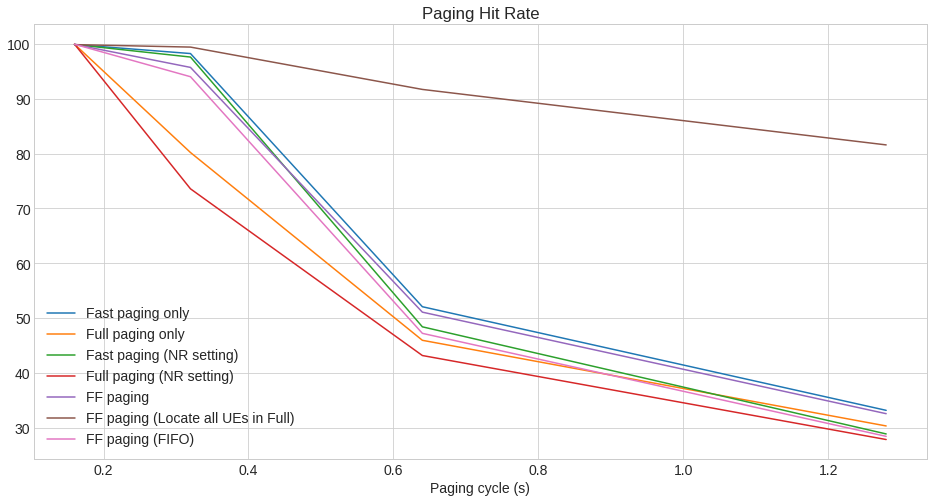

In [ ]:
from matplotlib import pyplot as plt
from matplotlib import rcParams
import numpy as np

rcParams.update({'font.size': 14})
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(16,8))

def plot_line(ll):
  x = label['paging_cycle']
  plt.plot(x, [s.get_paging_hit_rate() for s in result if s.label==ll], label=ll)

plot_line('Fast paging only')
plot_line('Full paging only')
plot_line('Fast paging (NR setting)')
plot_line('Full paging (NR setting)')
plot_line('FF paging')
plot_line('FF paging (Locate all UEs in Full)')
plot_line('FF paging (FIFO)')

plt.title('Paging Hit Rate')
plt.xlabel('Paging cycle (s)')
plt.legend();

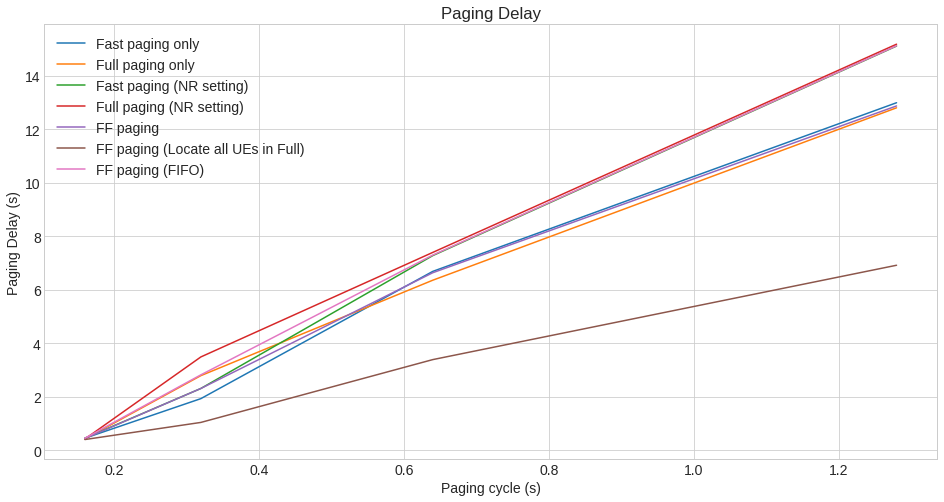

In [ ]:
from matplotlib import pyplot as plt
from matplotlib import rcParams
import numpy as np

rcParams.update({'font.size': 14})
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(16,8))

def plot_line(ll):
  x = label['paging_cycle']
  plt.plot(x, [s.get_paging_delay() for s in result if s.label==ll], label=ll)

plot_line('Fast paging only')
plot_line('Full paging only')
plot_line('Fast paging (NR setting)')
plot_line('Full paging (NR setting)')
plot_line('FF paging')
plot_line('FF paging (Locate all UEs in Full)')
plot_line('FF paging (FIFO)')

plt.title('Paging Delay')
plt.xlabel('Paging cycle (s)')
plt.ylabel('Paging Delay (s)')
plt.legend();

### Experiment 4

In [ ]:
mount_drive()
result = load_result('20200107_1411_Exp4') # beam stay time = {0.32:1, 1.28:1}
label = load_result('20200107_1415_Exp4_paramList')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


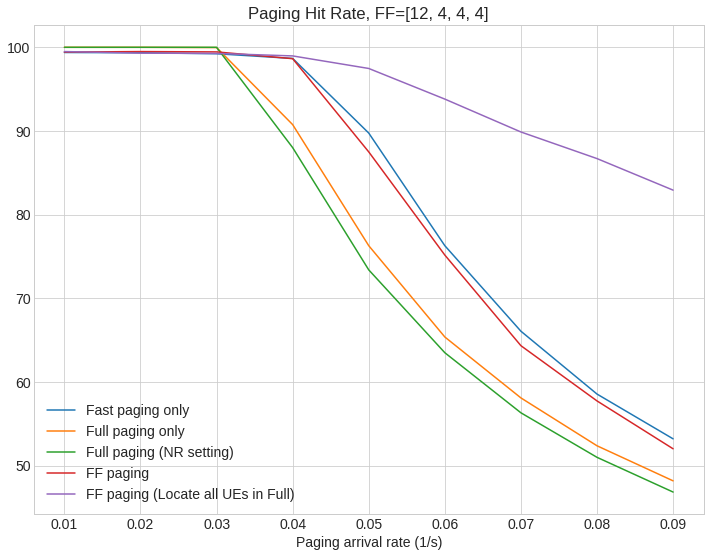

In [ ]:
from matplotlib import pyplot as plt
from matplotlib import rcParams
import numpy as np

rcParams.update({'font.size': 14})
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(12,9))

def plot_line(ll):
  x = label['paging_arrival_rate']
  plt.plot(x, [s.get_paging_hit_rate() for s in result if s.label==ll], label=ll)

if 1:
  plot_line('Fast paging only')
  plot_line('Full paging only')
  #plot_line('Fast paging (NR setting)')
  plot_line('Full paging (NR setting)')
if 1:
  plot_line('FF paging')
  plot_line('FF paging (Locate all UEs in Full)')
  #plot_line('FF paging (FIFO)')

plt.title('Paging Hit Rate, FF=[12, 4, 4, 4]')
plt.xlabel('Paging arrival rate (1/s)')
plt.legend();

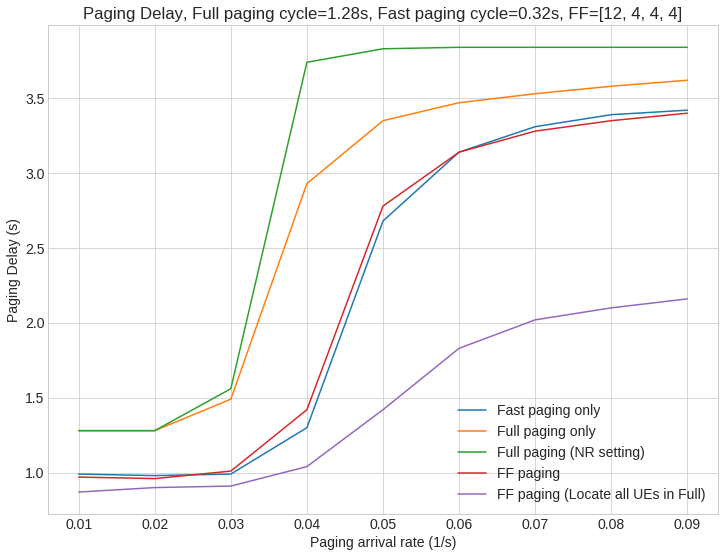

In [ ]:
from matplotlib import pyplot as plt
from matplotlib import rcParams
import numpy as np

rcParams.update({'font.size': 14})
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(12,9))

def plot_line(ll):
  x = label['paging_arrival_rate']
  plt.plot(x, [s.get_paging_delay() for s in result if s.label==ll], label=ll)

if 1:
  plot_line('Fast paging only')
  plot_line('Full paging only')
  #plot_line('Fast paging (NR setting)')
  plot_line('Full paging (NR setting)')
if 1:
  plot_line('FF paging')
  plot_line('FF paging (Locate all UEs in Full)')
  #plot_line('FF paging (FIFO)')

plt.title('Paging Delay, Full paging cycle=1.28s, Fast paging cycle=0.32s, FF=[12, 4, 4, 4]')
plt.xlabel('Paging arrival rate (1/s)')
plt.ylabel('Paging Delay (s)')
plt.legend();

### Experiment 5

In [ ]:
mount_drive()
result = load_result('20200108_1139_Exp5') # beam stay time = {0.32:1, 1.28:1}
label = load_result('20200108_1141_Exp5_paramList')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


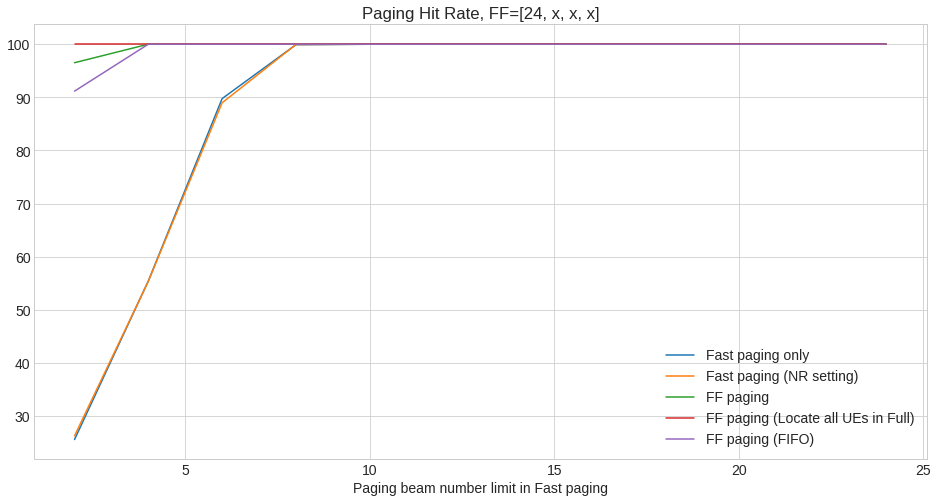

In [ ]:
from matplotlib import pyplot as plt
from matplotlib import rcParams
import numpy as np

rcParams.update({'font.size': 14})
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(16,8))

def plot_line(ll):
  x = label['paging_beam_limit']
  plt.plot(x, [s.get_paging_hit_rate() for s in result if s.label==ll], label=ll)

if 1:
  plot_line('Fast paging only')
  plot_line('Fast paging (NR setting)')
if 1:
  plot_line('FF paging')
  plot_line('FF paging (Locate all UEs in Full)')
  plot_line('FF paging (FIFO)')

plt.title('Paging Hit Rate, FF=[24, x, x, x]')
plt.xlabel('Paging beam number limit in Fast paging')
plt.legend();

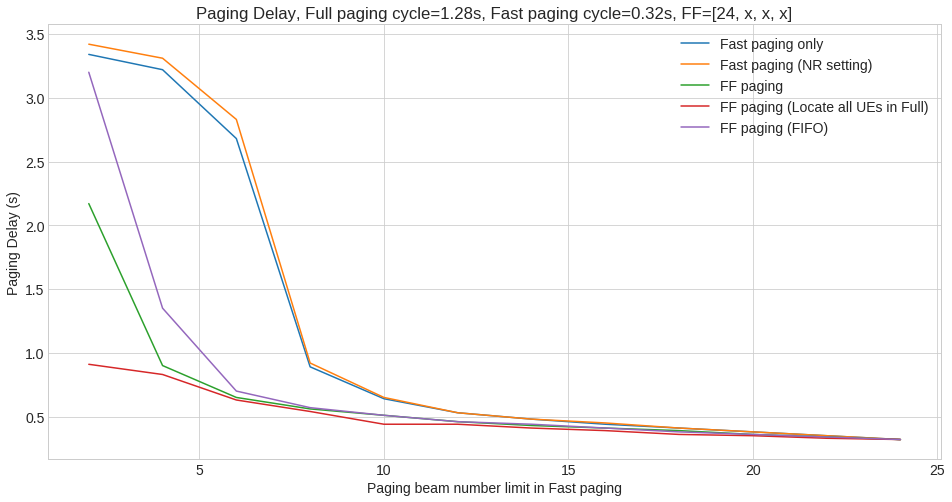

In [ ]:
from matplotlib import pyplot as plt
from matplotlib import rcParams
import numpy as np

rcParams.update({'font.size': 14})
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(16,8))

def plot_line(ll):
  x = label['paging_beam_limit']
  plt.plot(x, [s.get_paging_delay() for s in result if s.label==ll], label=ll)

if 1:
  plot_line('Fast paging only')
  plot_line('Fast paging (NR setting)')
if 1:
  plot_line('FF paging')
  plot_line('FF paging (Locate all UEs in Full)')
  plot_line('FF paging (FIFO)')

plt.title('Paging Delay, Full paging cycle=1.28s, Fast paging cycle=0.32s, FF=[24, x, x, x]')
plt.xlabel('Paging beam number limit in Fast paging')
plt.ylabel('Paging Delay (s)')
plt.legend();

### Experiment 6

In [ ]:
mount_drive()
result = load_result('20200109_0952_Exp6') # beam stay time = {0.32:1, 1.28:1}
label = load_result('20200109_0956_Exp6_paramList')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


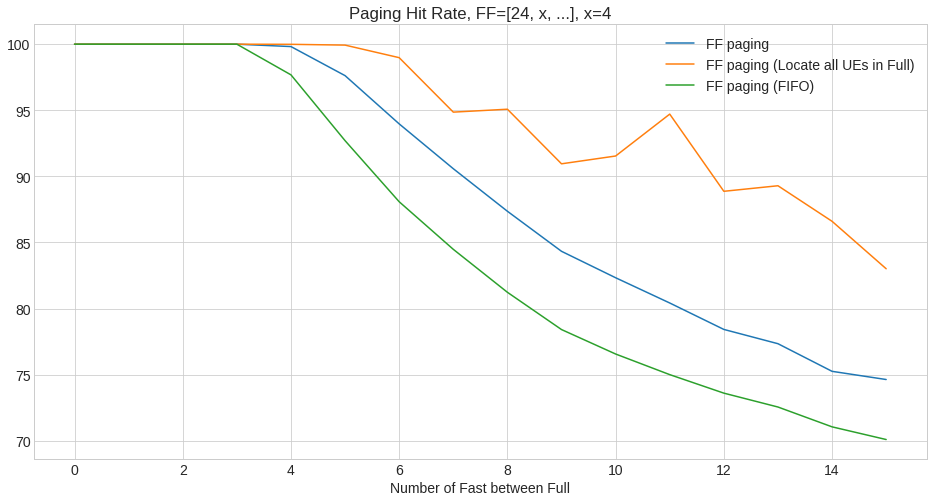

In [ ]:
from matplotlib import pyplot as plt
from matplotlib import rcParams
import numpy as np

rcParams.update({'font.size': 14})
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(16,8))

def plot_line(ll):
  x = label['ff_number']
  plt.plot(x, [s.get_paging_hit_rate() for s in result if s.label==ll], label=ll)

if 1:
  plot_line('FF paging')
  plot_line('FF paging (Locate all UEs in Full)')
  plot_line('FF paging (FIFO)')

plt.title('Paging Hit Rate, FF=[24, x, ...], x=4')
plt.xlabel('Number of Fast between Full')
plt.legend();

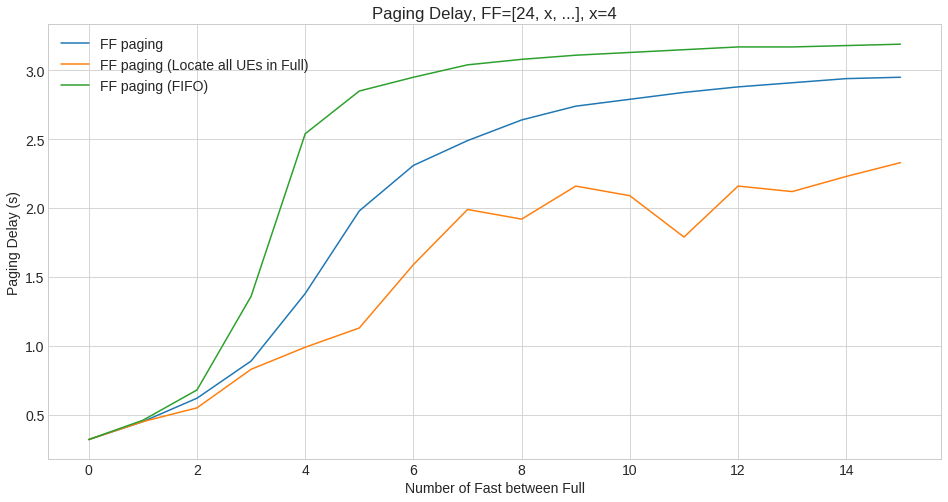

In [ ]:
from matplotlib import pyplot as plt
from matplotlib import rcParams
import numpy as np

rcParams.update({'font.size': 14})
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(16,8))

def plot_line(ll):
  x = label['ff_number']
  plt.plot(x, [s.get_paging_delay() for s in result if s.label==ll], label=ll)

if 1:
  plot_line('FF paging')
  plot_line('FF paging (Locate all UEs in Full)')
  plot_line('FF paging (FIFO)')

plt.title('Paging Delay, FF=[24, x, ...], x=4')
plt.xlabel('Number of Fast between Full')
plt.ylabel('Paging Delay (s)')
plt.legend();

### Experiment 1+4

In [ ]:
mount_drive()
result = load_result('20200107_2225_Exp1')
label = load_result('20200107_2229_Exp1_paramList')

result2 = load_result('20200107_1411_Exp4') # beam stay time = {0.32:1, 1.28:1}
label2 = load_result('20200107_1415_Exp4_paramList')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


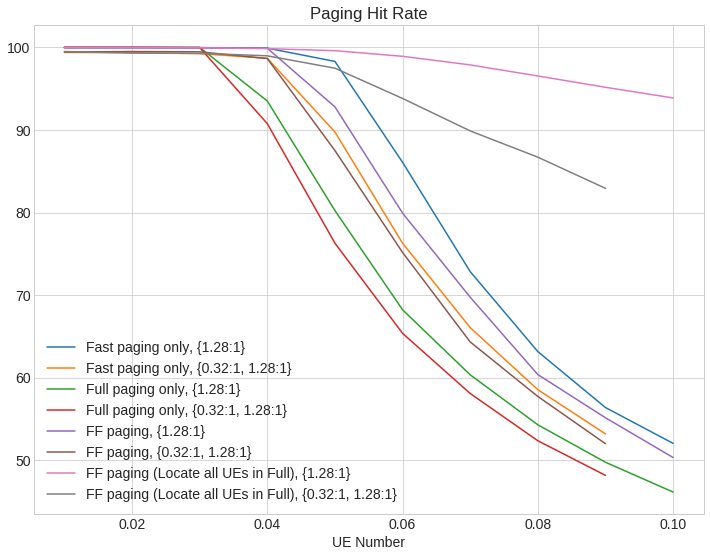

In [ ]:
from matplotlib import pyplot as plt
from matplotlib import rcParams
import numpy as np

rcParams.update({'font.size': 14})
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(12,9))

def plot_line(ll):
  x = label['paging_arrival_rate']
  plt.plot(x, [s.get_paging_hit_rate() for s in result if s.label==ll], label=ll+', {1.28:1}')

def plot_line2(ll):
  x = label2['paging_arrival_rate']
  plt.plot(x, [s.get_paging_hit_rate() for s in result2 if s.label==ll], label=ll+', {0.32:1, 1.28:1}')

plot_line('Fast paging only')
plot_line2('Fast paging only')
plot_line('Full paging only')
plot_line2('Full paging only')
#plot_line('Fast paging (NR setting)')
#plot_line('Full paging (NR setting)')
#plot_line2('Full paging (NR setting)')
plot_line('FF paging')
plot_line2('FF paging')
plot_line('FF paging (Locate all UEs in Full)')
plot_line2('FF paging (Locate all UEs in Full)')
#plot_line('FF paging (FIFO)')

plt.title('Paging Hit Rate')
plt.xlabel('paging_arrival_rate')
plt.legend();

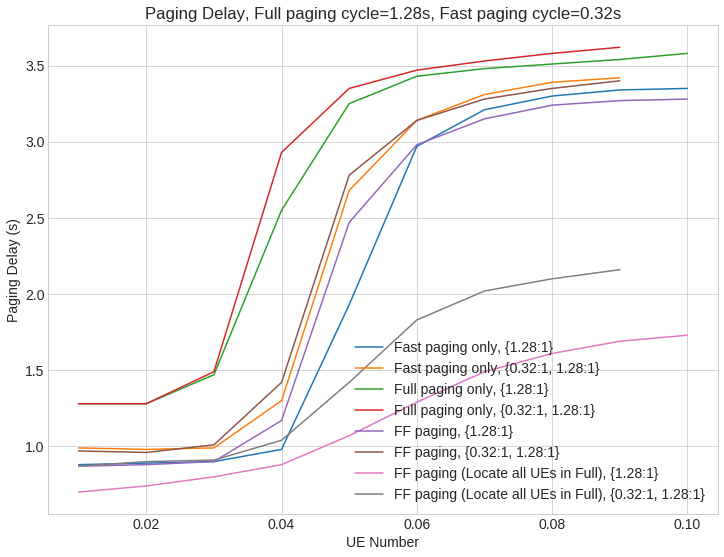

In [ ]:
from matplotlib import pyplot as plt
from matplotlib import rcParams
import numpy as np

rcParams.update({'font.size': 14})
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(12,9))

def plot_line(ll):
  x = label['paging_arrival_rate']
  plt.plot(x, [s.get_paging_delay() for s in result if s.label==ll], label=ll+', {1.28:1}')
  
def plot_line2(ll):
  x = label2['paging_arrival_rate']
  plt.plot(x, [s.get_paging_delay() for s in result2 if s.label==ll], label=ll+', {0.32:1, 1.28:1}')

plot_line('Fast paging only')
plot_line2('Fast paging only')
plot_line('Full paging only')
plot_line2('Full paging only')
#plot_line('Fast paging (NR setting)')
#plot_line('Full paging (NR setting)')
#plot_line2('Full paging (NR setting)')
plot_line('FF paging')
plot_line2('FF paging')
plot_line('FF paging (Locate all UEs in Full)')
plot_line2('FF paging (Locate all UEs in Full)')
#plot_line('FF paging (FIFO)')

plt.title('Paging Delay, Full paging cycle=1.28s, Fast paging cycle=0.32s')
plt.xlabel('paging_arrival_rate')
plt.ylabel('Paging Delay (s)')
plt.legend();

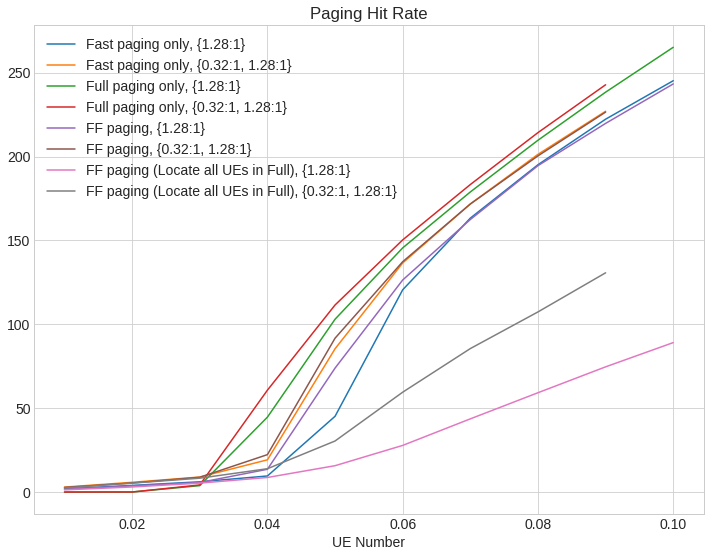

In [ ]:
from matplotlib import pyplot as plt
from matplotlib import rcParams
import numpy as np

rcParams.update({'font.size': 14})
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(12,9))

def plot_line(ll):
  x = label['paging_arrival_rate']
  plt.plot(x, [s.get_system_paging_delay() for s in result if s.label==ll], label=ll+', {1.28:1}')

def plot_line2(ll):
  x = label2['paging_arrival_rate']
  plt.plot(x, [s.get_system_paging_delay() for s in result2 if s.label==ll], label=ll+', {0.32:1, 1.28:1}')

plot_line('Fast paging only')
plot_line2('Fast paging only')
plot_line('Full paging only')
plot_line2('Full paging only')
#plot_line('Fast paging (NR setting)')
#plot_line('Full paging (NR setting)')
#plot_line2('Full paging (NR setting)')
plot_line('FF paging')
plot_line2('FF paging')
plot_line('FF paging (Locate all UEs in Full)')
plot_line2('FF paging (Locate all UEs in Full)')
#plot_line('FF paging (FIFO)')

plt.title('Paging Hit Rate')
plt.xlabel('paging_arrival_rate')
plt.legend();

### Experiment 7

In [ ]:
mount_drive()
result = load_result('20200210_0907_Exp7')
label = load_result('20200210_0910_Exp7_paramList')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


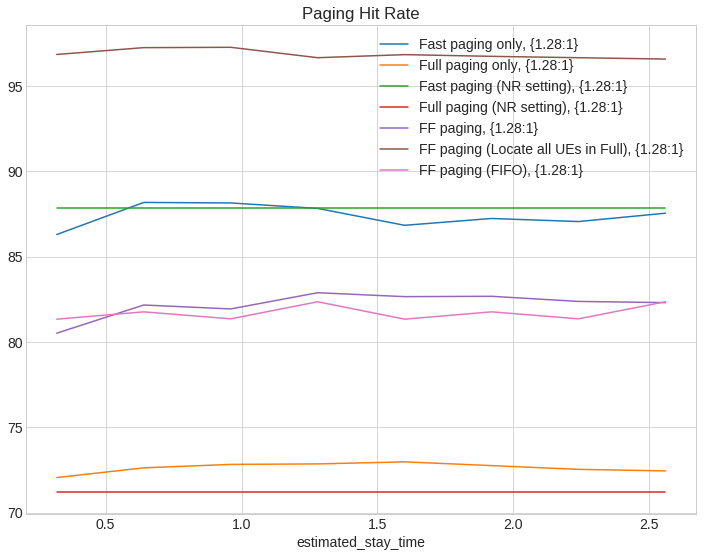

In [ ]:
from matplotlib import pyplot as plt
from matplotlib import rcParams
import numpy as np

rcParams.update({'font.size': 14})
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(12,9))

def plot_line(ll):
  x = label['estimated_stay_time']
  plt.plot(x, [s.get_paging_hit_rate() for s in result if s.label==ll], label=ll+', {1.28:1}')

plot_line('Fast paging only')
plot_line('Full paging only')
plot_line('Fast paging (NR setting)')
plot_line('Full paging (NR setting)')
plot_line('FF paging')
plot_line('FF paging (Locate all UEs in Full)')
plot_line('FF paging (FIFO)')

plt.title('Paging Hit Rate')
plt.xlabel('estimated_stay_time')
plt.legend();

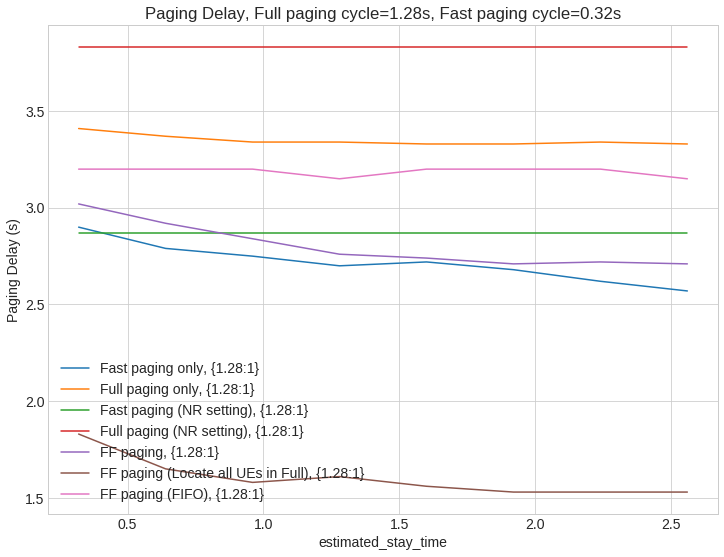

In [ ]:
from matplotlib import pyplot as plt
from matplotlib import rcParams
import numpy as np

rcParams.update({'font.size': 14})
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(12,9))

def plot_line(ll):
  x = label['estimated_stay_time']
  plt.plot(x, [s.get_paging_delay() for s in result if s.label==ll], label=ll+', {1.28:1}')
  
plot_line('Fast paging only')
plot_line('Full paging only')
plot_line('Fast paging (NR setting)')
plot_line('Full paging (NR setting)')
plot_line('FF paging')
plot_line('FF paging (Locate all UEs in Full)')
plot_line('FF paging (FIFO)')

plt.title('Paging Delay, Full paging cycle=1.28s, Fast paging cycle=0.32s')
plt.xlabel('estimated_stay_time')
plt.ylabel('Paging Delay (s)')
plt.legend();

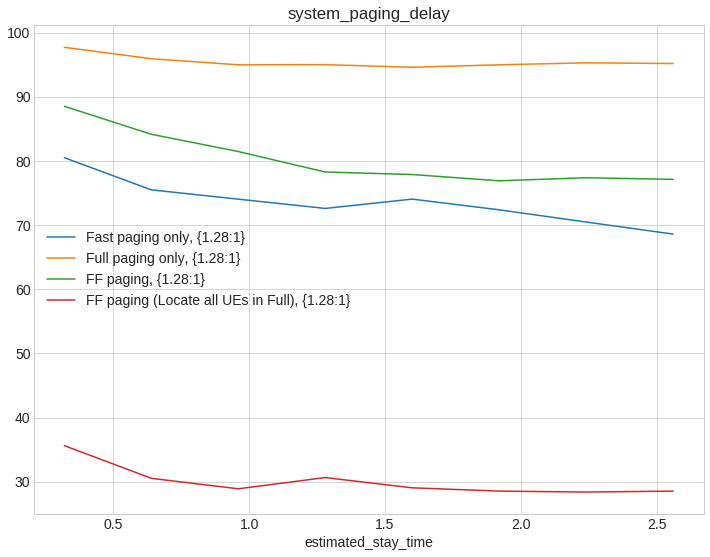

In [ ]:
from matplotlib import pyplot as plt
from matplotlib import rcParams
import numpy as np

rcParams.update({'font.size': 14})
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(12,9))

def plot_line(ll):
  x = label['estimated_stay_time']
  plt.plot(x, [s.get_system_paging_delay() for s in result if s.label==ll], label=ll+', {1.28:1}')

plot_line('Fast paging only')
plot_line('Full paging only')
#plot_line('Fast paging (NR setting)')
#plot_line('Full paging (NR setting)')
plot_line('FF paging')
plot_line('FF paging (Locate all UEs in Full)')
#plot_line('FF paging (FIFO)')

plt.title('system_paging_delay')
plt.xlabel('estimated_stay_time')
plt.legend();

### Experiment 8

In [ ]:
mount_drive()
if 0:
  result = load_result('20200629_0344_Exp8_0.04_') # arrival rate = 0.04
  label = load_result('20200629_0348_Exp8_0.04_paramList')
if 0:
  result = load_result('20200629_0521_Exp8_0.02_') # arrival rate = 0.02
  label = load_result('20200629_0523_Exp8_0.02_paramList')

if 0:
  result = load_result('20200722_1229_Exp8_0.02_')
  label = load_result('20200722_1231_Exp8_0.02_paramList')
if 0:
  result = load_result('20200722_1438_Exp8_0.04_')
  label = load_result('20200722_1444_Exp8_0.04_paramList')
  
if 0:
  result = load_result('20210616_0946_Exp8_0.02_')
  label = load_result('20210616_0948_Exp8_0.02_paramList')
if 1:
  result = load_result('20210616_0834_Exp8_0.04_')
  label = load_result('20210616_0839_Exp8_0.04_paramList')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

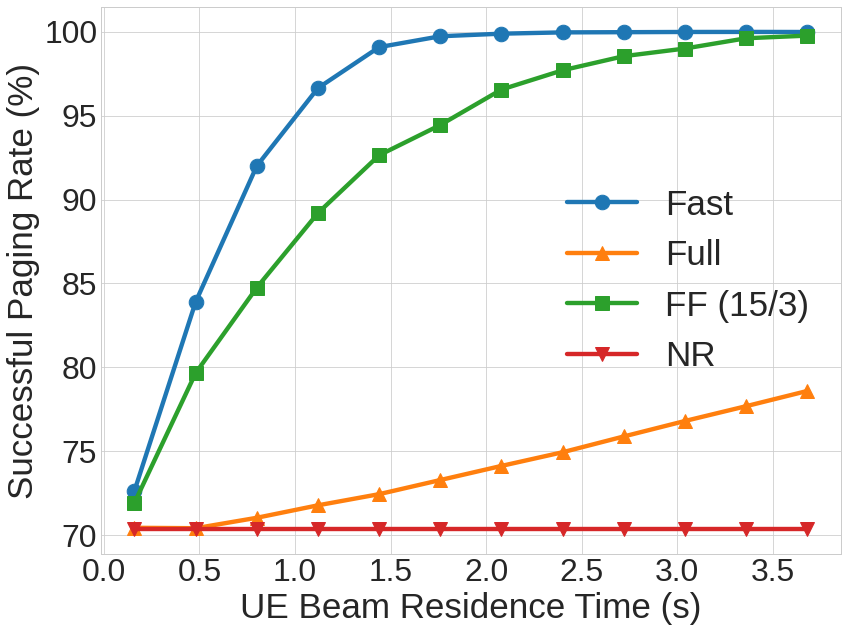

In [ ]:
from matplotlib import pyplot as plt
from matplotlib import rcParams
import numpy as np
fsize=35
rcParams.update({'font.size': 14})
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(12,9))

def plot_line(ll, ln='', ss='-'):
  x = label['beam_stay_time']
  if ln=='':
    ln=ll
  plt.plot(x, [s.get_paging_hit_rate() for s in result if s.label==ll], ss, label=ln, linewidth=fsize/8, markersize=fsize/2.4)

plot_line('Fast paging only', 'Fast', '-o')
plot_line('Full paging only', 'Full', '-^')
plot_line('FF paging', 'FF (15/3)', '-s')
#plot_line('Fast paging (NR setting)')
plot_line('Full paging (NR setting)', 'NR', '-v')
#plot_line('FF paging (Locate all UEs in Full)')
#plot_line('FF paging (FIFO)')

plt.xlabel('UE Beam Residence Time (s)', fontsize=fsize)
plt.ylabel('Successful Paging Rate (%)', fontsize=fsize)
plt.xticks(fontsize=fsize/1.1)
plt.yticks(fontsize=fsize/1.1)
plt.legend(fontsize=fsize);

download_plot('mobility_succ_rate_arri_rate_0.04')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

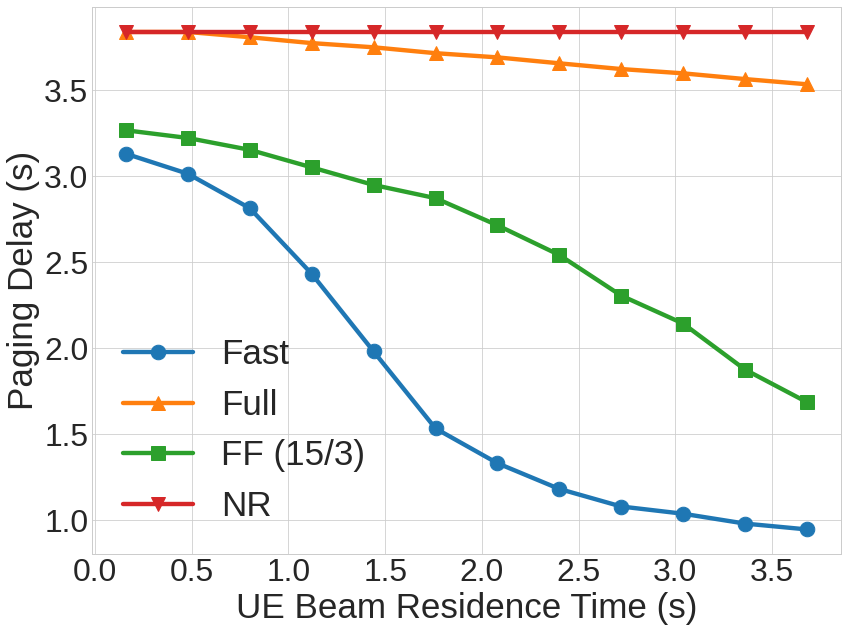

In [ ]:
from matplotlib import pyplot as plt
from matplotlib import rcParams
import numpy as np
fsize=35
rcParams.update({'font.size': 14})
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(12,9))

def plot_line(ll, ln='', ss='-'):
  x = label['beam_stay_time']
  if ln=='':
    ln=ll
  plt.plot(x, [s.get_paging_delay() for s in result if s.label==ll], ss, label=ln, linewidth=fsize/8, markersize=fsize/2.4)

plot_line('Fast paging only', 'Fast', '-o')
plot_line('Full paging only', 'Full', '-^')
plot_line('FF paging', 'FF (15/3)', '-s')
#plot_line('Fast paging (NR setting)')
plot_line('Full paging (NR setting)', 'NR', '-v')
#plot_line('FF paging (Locate all UEs in Full)')
#plot_line('FF paging (FIFO)')

plt.xlabel('UE Beam Residence Time (s)', fontsize=fsize)
plt.ylabel('Paging Delay (s)', fontsize=fsize)
plt.xticks(fontsize=fsize/1.1)
plt.yticks(fontsize=fsize/1.1)
plt.legend(fontsize=fsize);

download_plot('mobility_delay_arri_rate_0.04')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

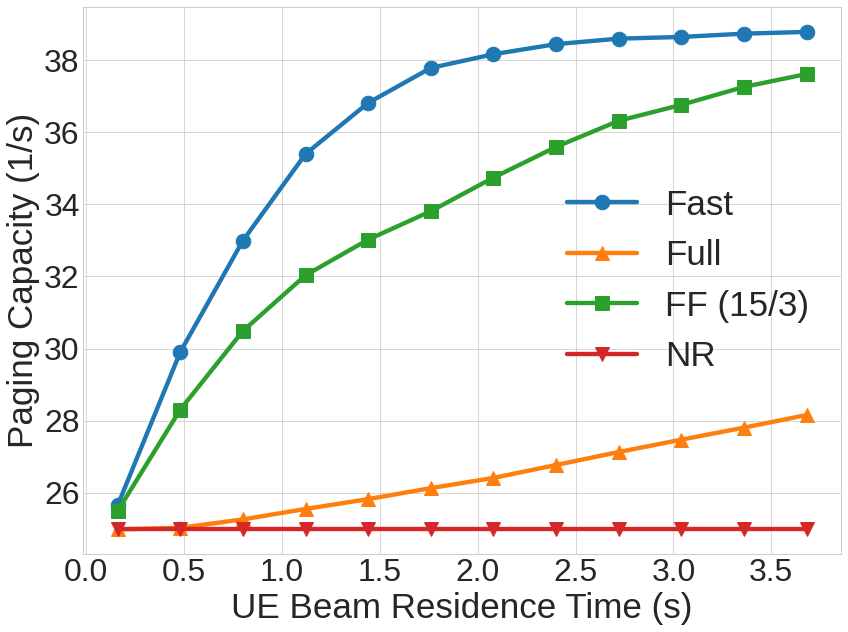

In [ ]:
from matplotlib import pyplot as plt
from matplotlib import rcParams
import numpy as np
fsize=35
rcParams.update({'font.size': 14})
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(12,9))

def plot_line(ll, ln='', ss='-'):
  x = label['beam_stay_time']
  if ln=='':
    ln=ll
  plt.plot(x, [s.get_throughput() for s in result if s.label==ll], ss, label=ln, linewidth=fsize/8, markersize=fsize/2.4)

plot_line('Fast paging only', 'Fast', '-o')
plot_line('Full paging only', 'Full', '-^')
plot_line('FF paging', 'FF (15/3)', '-s')
#plot_line('Fast paging (NR setting)')
plot_line('Full paging (NR setting)', 'NR', '-v')
#plot_line('FF paging (Locate all UEs in Full)')
#plot_line('FF paging (FIFO)')

plt.xlabel('UE Beam Residence Time (s)', fontsize=fsize)
plt.ylabel('Paging Capacity (1/s)', fontsize=fsize)
plt.xticks(fontsize=fsize/1.1)
plt.yticks(fontsize=fsize/1.1)
plt.legend(fontsize=fsize);

download_plot('mobility_capacity_arri_rate_0.04')

# Markov model

## Class

In [ ]:
import numpy as np
import time

class Markov:
  def __init__(self, ue_number=4, beam_number=6, max_attempt=2, pi_sc=64, resource_per_beam=2, paging_beam_limit=2, paging_arrival_rate=5e-2, beam_residence_time=0.64, paging_cycle=1.28):
    self.ue_number = ue_number
    self.beam_number = beam_number
    self.max_attempt = max_attempt
    self.pi_sc = pi_sc
    self.resource_per_beam = resource_per_beam
    self.paging_beam_limit = paging_beam_limit
    self.paging_arrival_rate = paging_arrival_rate
    self.beam_residence_time = beam_residence_time
    self.paging_cycle = paging_cycle

    self.setp = 0

    self.paging_arrival_probability = 1-np.exp(-self.paging_arrival_rate*self.paging_cycle)
    self.not_stay_probability = (1-np.exp(-self.paging_cycle/self.beam_residence_time))/self.beam_number
    self.t_mat = np.zeros((self.beam_number, self.beam_number), dtype=np.float64) + self.not_stay_probability
    for i in range(self.beam_number): self.t_mat[i,i] = 1 - (self.beam_number-1)*self.not_stay_probability

    self.pi, k, x = {}, tuple(np.zeros(self.ue_number, dtype=np.int32)), np.zeros((self.ue_number, self.beam_number), dtype=np.int32)
    x[:, 0] = self.pi_sc
    self.pi[k+tuple(x.reshape(self.ue_number*self.beam_number))] = 1.0

    self.C = {}

  def get_c(self, k, x):
    c, s, bss = np.zeros ((self.ue_number, self.beam_number), dtype=np.bool), np.zeros ((self.beam_number), dtype=np.bool), np.zeros (self.beam_number)
    # cc = (np.array(x, dtype=np.int32).reshape(self.ue_number,self.beam_number) * np.array(k, dtype=np.int32).reshape(self.ue_number, 1))
    cc = -np.log(1+1e-9-np.array(x, dtype=np.int32).reshape(self.ue_number,self.beam_number)) * np.array(k, dtype=np.int32).reshape(self.ue_number, 1)
    for b in range(self.beam_number):
      ue_id = [ue_id for ue_id in cc[:, b].argsort()[::-1][:self.resource_per_beam] if cc[ue_id, b] > 0]
      bss[b], c[ue_id, b] = cc[ue_id, b].sum(), 1
    s[ [ beam_id for beam_id in bss.argsort()[::-1][:self.paging_beam_limit ] if bss[beam_id]>0 ] ] = 1
    c[:, s==0] = 0
    return c
  
  def one_step(self):
    pi = {}
    for ck, p in self.pi.items():
      k, x = tuple(ck[:self.ue_number]), tuple(ck[self.ue_number:])
      if ck not in self.C: self.C[ck] = self.get_c(k, x)
      C = self.C[ck]
      cc, Ks = C.any(axis=1), [()]
      for i in range(self.ue_number):
        if k[i] in [self.max_attempt, 0]:
          Ks = [oo+(0,) for oo in Ks] + [oo+(1,) for oo in Ks]
        elif cc[i]:
          Ks = [oo+(0,) for oo in Ks] + [oo+(1,) for oo in Ks] + [oo+(k[i]+1,) for oo in Ks]
        else:
          Ks = [oo+(k[i]+1,) for oo in Ks]
      x, o = np.array(x, dtype=np.float64).reshape(self.ue_number,self.beam_number), {}
      for K in Ks:
        new_k, d = np.array(K, dtype=np.int32), {():p}
        for i in range(self.ue_number):
          if k[i] == 0:
            d = {nx+tuple(np.dot(x[i, :],self.t_mat)): d[nx]*(1-new_k[i]+(2*new_k[i]-1)*self.paging_arrival_probability) for nx in d}
          elif new_k[i] < 2:
            e = {nx + tuple(self.t_mat[j, :]*self.pi_sc): d[nx]*(1-new_k[i]+(2*new_k[i]-1)*self.paging_arrival_probability)*x[i,j]/self.pi_sc for j in range(self.beam_number) if C[i, j] for nx in d}
            if k[i] == self.max_attempt:
              xn = x[i,:].copy()
              ppn = xn[~C[i,:]].sum()/self.pi_sc
              xn[~C[i,:]] += xn[C[i,:]].sum()/(~C[i,:]).sum()
              xn[C[i,:]] = 0
              e.update({nx + tuple(np.dot(xn,self.t_mat)): d[nx]*ppn*(1-new_k[i]+(2*new_k[i]-1)*self.paging_arrival_probability) for nx in d})
            d = e
          elif new_k[i] == k[i]+1:
            xn = x[i,:].copy()
            ppn = xn[~C[i,:]].sum()/self.pi_sc
            xn[~C[i,:]] += xn[C[i,:]].sum()/(~C[i,:]).sum()
            xn[C[i,:]] = 0
            d = {nx + tuple(np.dot(xn,self.t_mat)): d[nx]*ppn for nx in d}
          else: assert(False, 'Unexpected k')
        o.update({K+self.round_nx(nx): d[nx] for nx in d})
      for ok in o:
        k, x = np.array(ok[:self.ue_number], dtype=np.int32), np.array(ok[self.ue_number:], dtype=np.int32).reshape(self.ue_number,self.beam_number)
        ki = np.lexsort(np.hstack([x,k.reshape(self.ue_number,1)]).transpose())
        nck = tuple(k[ki]) + tuple(x[ki, :].reshape(self.ue_number*self.beam_number))
        if nck in pi: pi[nck] += o[ok]
        else: pi[nck] = o[ok]
    pi = { ck:pi[ck] for ck in pi if int(pi[ck]*1e15+0.5)/1e15 >= 1e-15}
    t = sum(pi.values())
    self.pi = { ck: pi[ck]/t for ck in pi }
    self.setp += 1
    return self

  def get_pi_k(self):
    kk = {}
    for kx, v in self.pi.items():
      k = tuple(kx[0:self.ue_number])
      if k in kk: kk[k] += v
      else: kk[k] = v
    ek = int(sum([sum(k)*kk[k]*self.paging_cycle for k in kk])*1e7+0.5)/1e7
    kk = {k: int(kk[k]*1e7+5)/1e7 for k in kk}
    return (ek, kk)

  def round_nx(self, nx):
    nxx = np.array(nx, dtype=np.int32).reshape(self.ue_number,self.beam_number)
    df = self.pi_sc - nxx.sum(axis=1)
    dx = nxx.argmax(axis=1)
    for i in range(self.ue_number): nxx[i, dx[i]] += df[i]
    return tuple(nxx.reshape(self.ue_number*self.beam_number))

def mount_drive():
  from google.colab import drive
  drive.mount('/content/drive')

def save_result(fname, result):
  import pickle, gzip, datetime
  with gzip.open('/content/drive/Shared drives/sakl-cc/paging/{}_{}.pickle.gz'.format(datetime.datetime.now().strftime("%Y%m%d_%H%M"), fname), 'wb') as fout:
    pickle.dump(result, fout)

def load_result(fname):
  import pickle, gzip
  with gzip.open('/content/drive/Shared drives/sakl-cc/paging/{}.pickle.gz'.format(fname), 'rb') as fin:
    result = pickle.load(fin)
  return result
  
def download_plot(filename):
  from google.colab import files
  from matplotlib import rc
  rc('pdf', fonttype=42)
  plt.tight_layout()
  plt.savefig(filename+'.pdf')
  files.download(filename+'.pdf')

## Convergence

In [ ]:
time_budget = 8*3600
m, p, t = Markov(ue_number=4, beam_number=6, max_attempt=3, pi_sc=300, resource_per_beam=2, paging_beam_limit=2, paging_arrival_rate=0.05, beam_residence_time=0.64, paging_cycle=1.28), [], []
avgm = 0
for i in range (7):
  t.append(time.process_time())
  p.append(m.one_step().get_pi_k())
  x = time.process_time()-t[-1]
  time_budget -= x
  avgm = 0.3*avgm + 0.7*p[-1][0]
  print (i, x, round(abs(p[-1][0] - avgm), 5), p[-1][0])
  if time_budget <= 0: break
  if abs(p[-1][0] - avgm) <= 1e-5: break
t.append(time.process_time())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log


0 0.006612664000016366 0.09522 0.3174144
1 0.010846135000008417 0.21311 0.9325651
2 0.019955476999996336 0.33226 1.8269939
3 0.0591747150000117 0.0716 1.7334076
4 0.05058102199998871 0.00659 1.6837593
5 0.0509843670000123 0.00464 1.6926392
6 0.06402995400000577 0.00215 1.6951666


In [ ]:
time_budget = 8*3600
m, p, t = Markov(ue_number=6, beam_number=6, max_attempt=3, pi_sc=300, resource_per_beam=2, paging_beam_limit=2, paging_arrival_rate=0.05, beam_residence_time=0.64, paging_cycle=1.28), [], []
avgm = 0
for i in range (7):
  t.append(time.process_time())
  p.append(m.one_step().get_pi_k())
  x = time.process_time()-t[-1]
  time_budget -= x
  avgm = 0.3*avgm + 0.7*p[-1][0]
  print (i, x, round(abs(p[-1][0] - avgm), 5), p[-1][0])
  if time_budget <= 0: break
  if abs(p[-1][0] - avgm) <= 1e-5: break
t.append(time.process_time())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log


0 0.020293745999993007 0.14284 0.4761216
1 0.04801909500000079 0.31967 1.3988477
2 0.09864421099999277 0.49839 2.7404909
3 0.48368086800002175 0.1074 2.6001113
4 0.48145059000000856 0.00988 2.525639
5 0.4618317829999796 0.00696 2.5389587
6 0.4642316219999998 0.00323 2.5427499


In [ ]:
time_budget = 8*3600
m, p, t = Markov(ue_number=8, beam_number=6, max_attempt=3, pi_sc=300, resource_per_beam=2, paging_beam_limit=2, paging_arrival_rate=0.05, beam_residence_time=0.64, paging_cycle=1.28), [], []
avgm = 0
for i in range (7):
  t.append(time.process_time())
  p.append(m.one_step().get_pi_k())
  x = time.process_time()-t[-1]
  time_budget -= x
  avgm = 0.3*avgm + 0.7*p[-1][0]
  print (i, x, round(abs(p[-1][0] - avgm), 5), p[-1][0])
  if time_budget <= 0: break
  if abs(p[-1][0] - avgm) <= 1e-5: break
t.append(time.process_time())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log


0 0.0881219759999965 0.19045 0.6348288
1 0.20152655499998673 0.42623 1.8651302
2 0.37559119099998384 0.66452 3.6539879
3 3.350807145999994 0.14321 3.4668151
4 3.527426838999986 0.01317 3.3675186
5 3.815550016000003 0.00928 3.3852783
6 3.256641247999994 0.0043 3.3903332


## Match simulation and model

In [ ]:
mount_drive()
paging_arrival_rate = np.arange(0.01, 0.11, 0.01)
time_budget = np.zeros(len(paging_arrival_rate)) + 8*3600 / len(paging_arrival_rate)
result = []
for a in paging_arrival_rate:
  m, p, t = Markov(ue_number=4, beam_number=6, max_attempt=2, pi_sc=30000, resource_per_beam=2, paging_beam_limit=2, paging_arrival_rate=a, beam_residence_time=0.64, paging_cycle=1.28), [], []
  avgm = 0
  for i in range (5):
    t.append(time.process_time())
    p.append(m.one_step().get_pi_k())
    x = time.process_time()-t[-1]
    time_budget[paging_arrival_rate==a] -= x
    avgm = 0.3*avgm + 0.7*p[-1][0]
    print (a, i, round(abs(p[-1][0] - avgm), 5), p[-1][0])
    if time_budget[paging_arrival_rate==a] <= 0: break
    if abs(p[-1][0] - avgm) <= 1e-5: break
  t.append(time.process_time())
  result.append((m,p,t))
save_result('Markov', result)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
0.01 0 0.01954 0.0651184
0.01 1 0.04468 0.1945269
0.01 2 0.01291 0.192881
0.01 3 0.00388 0.1929019
0.01 4 0.00116 0.1929017
0.02 0 0.03882 0.1294085
0.02 1 0.08831 0.3849547
0.02 2 0.02456 0.3784957


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log


0.02 3 0.00742 0.378659
0.02 4 0.00222 0.3786549
0.03 0 0.05786 0.192881
0.03 1 0.13091 0.5713767
0.03 2 0.03499 0.557118
0.03 3 0.01066 0.5576552
0.03 4 0.00319 0.5576349
0.04 0 0.07666 0.2555462
0.04 1 0.1725 0.7538839
0.04 2 0.04429 0.7290112
0.04 3 0.01366 0.7302526
0.04 4 0.00408 0.7301907
0.05 0 0.09522 0.3174144
0.05 1 0.21311 0.9325651
0.05 2 0.05249 0.8944288
0.05 3 0.01646 0.8967931
0.05 4 0.00489 0.8966465
0.060000000000000005 0 0.11355 0.3784957
0.060000000000000005 1 0.25277 1.107507
0.060000000000000005 2 0.05966 1.0536148
0.060000000000000005 3 0.01909 1.0575988
0.060000000000000005 4 0.00564 1.0573043
0.06999999999999999 0 0.13164 0.4388002
0.06999999999999999 1 0.29149 1.2787941
0.06999999999999999 2 0.06585 1.206804
0.06999999999999999 3 0.02161 1.2129738
0.06999999999999999 4 0.00632 1.212445
0.08 0 0.1495 0.4983377
0.08 1 0.3293 1.4465092
0.08 2 0.0711 1.3542222
0.08 3 0.02403 1.3632046
0.08 4 0.00695 1.3623303
0.09 0 0.16714 0.557118
0.09 1 0.36623 1.6107328
0.09 2

In [ ]:
mount_drive()
paging_arrival_rate = np.arange(0.01, 0.11, 0.01)
time_budget = np.zeros(len(paging_arrival_rate)) + 8*3600 / len(paging_arrival_rate)
result = []
for a in paging_arrival_rate:
  m, p, t = Markov(ue_number=4, beam_number=6, max_attempt=3, pi_sc=30000, resource_per_beam=2, paging_beam_limit=2, paging_arrival_rate=a, beam_residence_time=0.64, paging_cycle=1.28), [], []
  avgm = 0
  for i in range (5):
    t.append(time.process_time())
    p.append(m.one_step().get_pi_k())
    x = time.process_time()-t[-1]
    time_budget[paging_arrival_rate==a] -= x
    avgm = 0.3*avgm + 0.7*p[-1][0]
    print (a, i, round(abs(p[-1][0] - avgm), 5), p[-1][0])
    if time_budget[paging_arrival_rate==a] <= 0: break
    if abs(p[-1][0] - avgm) <= 1e-5: break
  t.append(time.process_time())
  result.append((m,p,t))
save_result('Markov', result)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
0.01 0 0.01954 0.0651184
0.01 1 0.04468 0.1945269
0.01 2 0.07127 0.3874078
0.01 3 0.02015 0.3833088
0.01 4 0.00533 0.3809078
0.02 0 0.03882 0.1294085
0.02 1 0.08831 0.3849547
0.02 2 0.14004 0.7634504


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log


0.02 3 0.0372 0.747425
0.02 4 0.00841 0.7382635
0.03 0 0.05786 0.192881
0.03 1 0.13091 0.5713767
0.03 2 0.20641 1.1284947
0.03 3 0.05135 1.0932482
0.03 4 0.00951 1.0735883
0.04 0 0.07666 0.2555462
0.04 1 0.1725 0.7538839
0.04 2 0.27045 1.4828951
0.04 3 0.06276 1.4216365
0.04 4 0.00883 1.388308
0.05 0 0.09522 0.3174144
0.05 1 0.21311 0.9325651
0.05 2 0.33226 1.8269939
0.05 3 0.0716 1.7334076
0.05 4 0.00659 1.6837593
0.060000000000000005 0 0.11355 0.3784957
0.060000000000000005 1 0.25277 1.107507
0.060000000000000005 2 0.39191 2.1611218
0.060000000000000005 3 0.07804 2.0293412
0.060000000000000005 4 0.00297 1.9611947
0.06999999999999999 0 0.13164 0.4388002
0.06999999999999999 1 0.29149 1.2787941
0.06999999999999999 2 0.44949 2.4855981
0.06999999999999999 3 0.08222 2.310181
0.06999999999999999 4 0.00185 2.2217879
0.08 0 0.1495 0.4983377
0.08 1 0.3293 1.4465092
0.08 2 0.50506 2.8007313
0.08 3 0.08429 2.5766357
0.08 4 0.00771 2.4666387
0.09 0 0.16714 0.557118
0.09 1 0.36623 1.6107328
0.09 2

In [ ]:
mount_drive()
paging_arrival_rate = np.arange(0.01, 0.11, 0.01)
time_budget = np.zeros(len(paging_arrival_rate)) + 8*3600 / len(paging_arrival_rate)
result = []
for a in paging_arrival_rate:
  m, p, t = Markov(ue_number=4, beam_number=6, max_attempt=4, pi_sc=30000, resource_per_beam=2, paging_beam_limit=2, paging_arrival_rate=a, beam_residence_time=0.64, paging_cycle=1.28), [], []
  avgm = 0
  for i in range (5):
    t.append(time.process_time())
    p.append(m.one_step().get_pi_k())
    x = time.process_time()-t[-1]
    time_budget[paging_arrival_rate==a] -= x
    avgm = 0.3*avgm + 0.7*p[-1][0]
    print (a, i, round(abs(p[-1][0] - avgm), 5), p[-1][0])
    if time_budget[paging_arrival_rate==a] <= 0: break
    if abs(p[-1][0] - avgm) <= 1e-5: break
  t.append(time.process_time())
  result.append((m,p,t))
save_result('Markov', result)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
0.01 0 0.01954 0.0651184
0.01 1 0.04468 0.1945269
0.01 2 0.07127 0.3874078
0.01 3 0.09804 0.642954
0.01 4 0.02721 0.6356049
0.02 0 0.03882 0.1294085
0.02 1 0.08831 0.3849547
0.02 2 0.14004 0.7634504


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log


0.02 3 0.19151 1.2617882
0.02 4 0.04887 1.2331672
0.03 0 0.05786 0.192881
0.03 1 0.13091 0.5713767
0.03 2 0.20641 1.1284947
0.03 3 0.28063 1.8575059
0.03 4 0.06537 1.7947961
0.04 0 0.07666 0.2555462
0.04 1 0.1725 0.7538839
0.04 2 0.27045 1.4828951
0.04 3 0.36559 2.4310666
0.04 4 0.0771 2.3224834
0.05 0 0.09522 0.3174144
0.05 1 0.21311 0.9325651
0.05 2 0.33226 1.8269939
0.05 3 0.4466 2.9833871
0.05 4 0.0844 2.8181101
0.060000000000000005 0 0.11355 0.3784957
0.060000000000000005 1 0.25277 1.107507
0.060000000000000005 2 0.39191 2.1611218
0.060000000000000005 3 0.52384 3.5153439
0.060000000000000005 4 0.08758 3.2834526
0.06999999999999999 0 0.13164 0.4388002
0.06999999999999999 1 0.29149 1.2787941
0.06999999999999999 2 0.44949 2.4855981
0.06999999999999999 3 0.5975 4.0277753
0.06999999999999999 4 0.08697 3.7201888
0.08 0 0.1495 0.4983377
0.08 1 0.3293 1.4465092
0.08 2 0.50506 2.8007313
0.08 3 0.66774 4.5214826
0.08 4 0.08285 4.1299036
0.09 0 0.16714 0.557118
0.09 1 0.36623 1.6107328
0.09 

## Result

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

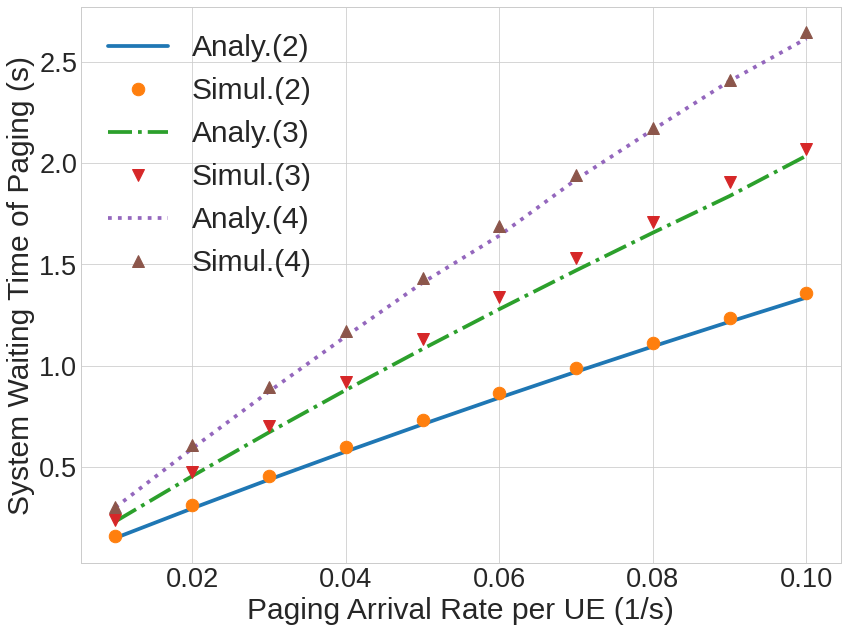

In [ ]:
from matplotlib import pyplot as plt
from matplotlib import rcParams
import numpy as np

fsize=30

rcParams.update({'font.size': 14})
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(12,9))

max2 = [0.160064, 0.312307, 0.458266, 0.598502, 0.732762, 0.864397, 0.99159, 1.112653, 1.236941, 1.358822]
markov_max2 = [0.1505482, 0.2966674, 0.4386779, 0.576856, 0.7114404, 0.8426389, 0.9706325, 1.0955802, 1.2176222, 1.3368829]

max3 = [0.239181, 0.475686, 0.701453, 0.917786, 1.132442, 1.339469, 1.532186, 1.711078, 1.907264, 2.071386]
markov_max3 = [0.2323329, 0.4559145, 0.6717071, 0.8804931, 1.0829074, 1.279464, 1.470579, 1.6565887, 1.8377653, 2.0365276]

max4 = [0.305958, 0.607846, 0.897549, 1.171328, 1.43415, 1.692198, 1.942899, 2.172378, 2.411226, 2.645286]
markov_max4 = [0.3016286, 0.5921438, 0.8729612, 1.1452277, 1.4098682, 1.6422512, 1.9190909, 2.1647347, 2.4049263, 2.6146202]

paging_arrival_rate = np.arange(0.01, 0.11, 0.01)

plt.plot(paging_arrival_rate, markov_max2, '-', label='Analy.(2)', linewidth=fsize/8, markersize=fsize/2.4)
plt.plot(paging_arrival_rate, max2, 'o', label='Simul.(2)', linewidth=fsize/8, markersize=fsize/2.4)

plt.plot(paging_arrival_rate, markov_max3, '-.', label='Analy.(3)', linewidth=fsize/8, markersize=fsize/2.4)
plt.plot(paging_arrival_rate, max3, 'v', label='Simul.(3)', linewidth=fsize/8, markersize=fsize/2.4)

plt.plot(paging_arrival_rate, markov_max4, ':', label='Analy.(4)', linewidth=fsize/8, markersize=fsize/2.4)
plt.plot(paging_arrival_rate, max4, '^', label='Simul.(4)', linewidth=fsize/8, markersize=fsize/2.4)

plt.xlabel('Paging Arrival Rate per UE (1/s)', fontsize=fsize)
plt.ylabel('System Waiting Time of Paging (s)', fontsize=fsize)
plt.xticks(fontsize=fsize/1.1)
plt.yticks(fontsize=fsize/1.1)
plt.legend(fontsize=fsize);

download_plot('match_markov_simulation')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

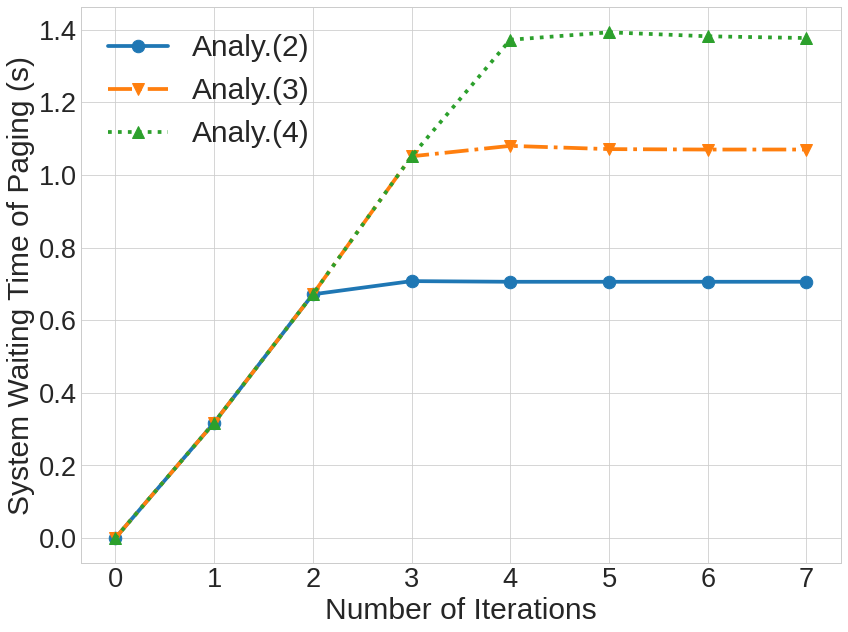

In [ ]:
from matplotlib import pyplot as plt
from matplotlib import rcParams
import numpy as np

fsize=30

rcParams.update({'font.size': 14})
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(12,9))

max2 = [0, 0.3174144, 0.6710783, 0.7074601, 0.7056301, 0.7056107, 0.7056573, 0.7056949]
max3 = [0, 0.3174144, 0.6710783, 1.0511588, 1.079938, 1.0709608, 1.0697947, 1.0698644]
max4 = [0, 0.3174144, 0.6710783, 1.0511588, 1.3721046, 1.3925906, 1.3817088, 1.3768662]

iter = range(8)

plt.plot(iter, max2, 'o-', label='Analy.(2)', linewidth=fsize/8, markersize=fsize/2.4)

plt.plot(iter, max3, 'v-.', label='Analy.(3)', linewidth=fsize/8, markersize=fsize/2.4)

plt.plot(iter, max4, '^:', label='Analy.(4)', linewidth=fsize/8, markersize=fsize/2.4)

plt.xlabel('Number of Iterations', fontsize=fsize)
plt.ylabel('System Waiting Time of Paging (s)', fontsize=fsize)
plt.xticks(fontsize=fsize/1.1)
plt.yticks(fontsize=fsize/1.1)
plt.legend(fontsize=fsize);

download_plot('markov_convergence')

# Figure

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

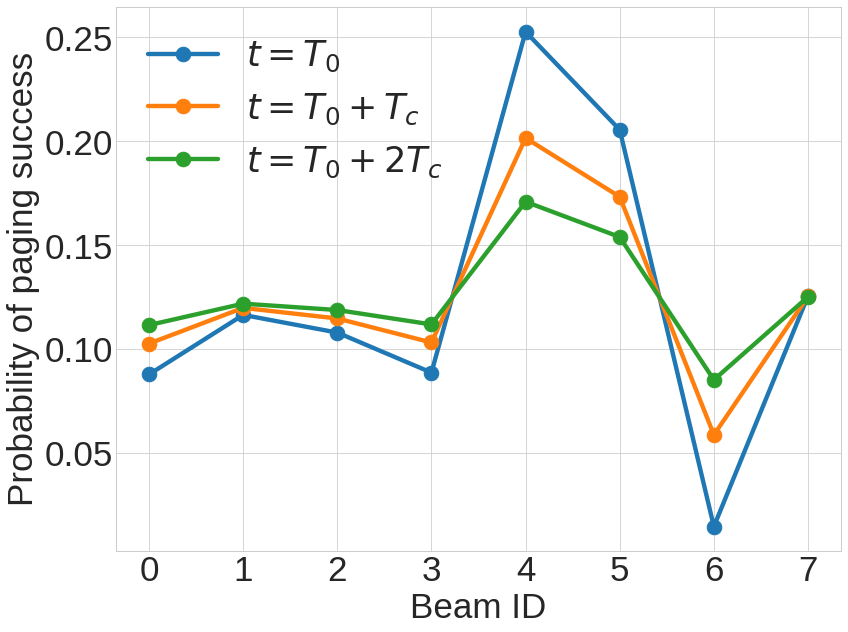

In [ ]:
from matplotlib import pyplot as plt
from matplotlib import rcParams
import numpy as np

rcParams.update({'font.size': 14})
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(12,9))

beamN = 8
x = np.random.rand(beamN)
x[4:6] += 1
x /= sum(x)
p = 0.4
A = p/beamN + np.zeros((beamN,beamN))
for i in range(beamN): A[i, i] = 1-(p/beamN*(beamN-1))
fsize=35

plt.plot(range(beamN), x, 'o-', linewidth=fsize/8, markersize=fsize/2.4, label='$t = T_0$')
plt.plot(range(beamN), np.dot(x, A), 'o-', linewidth=fsize/8, markersize=fsize/2.4, label='$t = T_0+T_c$')
plt.plot(range(beamN), np.dot(np.dot(x, A), A), 'o-', linewidth=fsize/8, markersize=fsize/2.4, label='$t = T_0+2T_c$')

plt.xlabel('Beam ID', fontsize=fsize)
plt.ylabel('Probability of paging success', fontsize=fsize)
plt.xticks(fontsize=fsize)
plt.yticks(fontsize=fsize)
plt.legend(fontsize=fsize);

download_plot('example_transistion_none')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

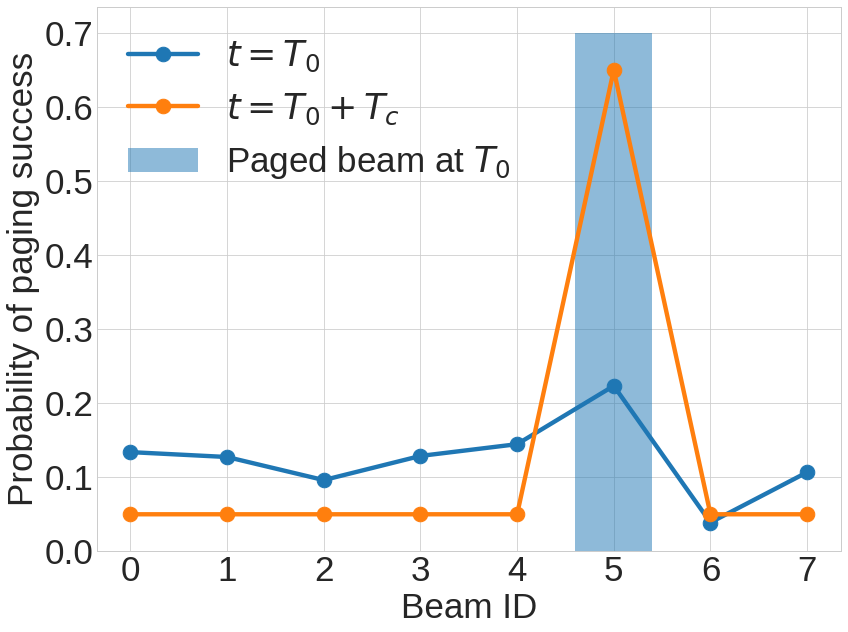

In [ ]:
from matplotlib import pyplot as plt
from matplotlib import rcParams
import numpy as np

rcParams.update({'font.size': 14})
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(12,9))

beamN = 8
x = np.random.rand(beamN)
x[4:6] += 1
x /= sum(x)
a = np.argmax(x)
p = 0.4
A = p/beamN + np.zeros((beamN,beamN))
for i in range(beamN): A[i, i] = 1-(p/beamN*(beamN-1))
fsize=35

plt.bar(a, 0.7, alpha=0.5, label='Paged beam at $T_0$')
plt.plot(range(beamN), x, 'o-', linewidth=fsize/8, markersize=fsize/2.4, label='$t = T_0$')
x = np.zeros(beamN)
x[a] = 1
plt.plot(range(beamN), np.dot(x, A), 'o-', linewidth=fsize/8, markersize=fsize/2.4, label='$t = T_0+T_c$')

plt.xlabel('Beam ID', fontsize=fsize)
plt.ylabel('Probability of paging success', fontsize=fsize)
plt.xticks(fontsize=fsize)
plt.yticks(fontsize=fsize)
plt.legend(fontsize=fsize);

download_plot('example_transistion_success')

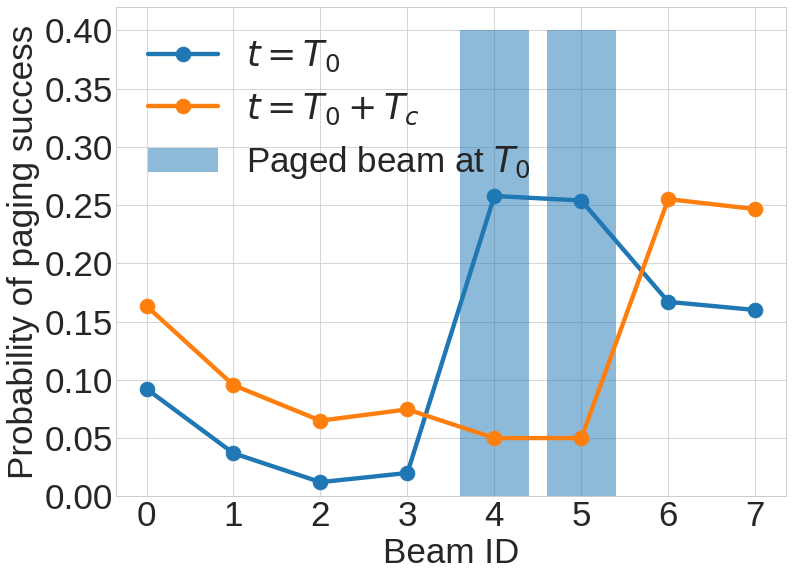

In [ ]:
from matplotlib import pyplot as plt
from matplotlib import rcParams
import numpy as np

rcParams.update({'font.size': 14})
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(12,9))

beamN = 8
x = np.random.rand(beamN)
x[4:6] += 1
x /= sum(x)
p = 0.4
A = p/beamN + np.zeros((beamN,beamN))
for i in range(beamN): A[i, i] = 1-(p/beamN*(beamN-1))
fsize=35

plt.bar([4,5], 0.4, alpha=0.5, label='Paged beam at $T_0$')
plt.plot(range(beamN), x, 'o-', linewidth=fsize/8, markersize=fsize/2.4, label='$t = T_0$')
x[4:6] = 0
x /= sum(x)
plt.plot(range(beamN), np.dot(x, A), 'o-', linewidth=fsize/8, markersize=fsize/2.4, label='$t = T_0+T_c$')

plt.xlabel('Beam ID', fontsize=fsize)
plt.ylabel('Probability of paging success', fontsize=fsize)
plt.xticks(fontsize=fsize)
plt.yticks(fontsize=fsize)
plt.legend(fontsize=fsize);

download_plot('example_transistion_fail')

# Verify Beam Residence Model

In [ ]:
import numpy as np
from google.colab import files
from matplotlib import rc
from matplotlib import rcParams

sind = lambda a: np.sin(a*np.pi/180)
cosd = lambda a: np.cos(a*np.pi/180)
dist = lambda p, q=np.zeros(2), a=0: np.sum((p-q)**2, a)**0.5

# TR38.901 Figure 7.7.4-2 Simplified antenna pattern [ITU-R M.2135]. Modified and add BF gain
antenna_gain = lambda a, b, n: -np.min(np.array([12*(a/b)**2-10*np.log10(n),a-a+20]), axis=0)
# TR38.901 NLOS
pathloss = lambda d, fc: 32.4+20*np.log10(fc)+30*np.log10(d)

v = 120 # kmph
dt = 0.32 # sec
isd = 200 # meter

nslot = 1e5

ns = 95
rxa = 0.7 # L1 filter

#f, nb = 6e9, 8
f, nb = 28e9, 64

bw = 120/nb
bd = np.arange(nb*3)*bw
bbest = []

ld = 299792458 / f

#========================UE
p = np.random.rand(2) * isd - isd/2
while dist(p) >= isd*0.4 or dist(p) <= isd*0.05:
  p = np.random.rand(2) * isd - isd/2
v = v * dt / 3.6
d = np.random.rand() * 360
d = v * np.array([cosd(d), sind(d)])
#========================Scatter
sp = np.random.rand(ns, 2) * isd - isd/2
for i in range(ns):
  while dist(sp[i,:]) <= isd*0.05:
    sp[i,:] = np.random.rand(1, 2) * isd - isd/2
sd = dist(sp, a=1)
sa = (180*np.arctan(sp[:,1]/sp[:,0])/np.pi + (sp[:,0]<0)*180)
sa = np.abs((sa+(sa<0)*360).reshape(sa.size,1) - bd.reshape(1,nb*3))
sa = 30+antenna_gain(sa-(sa>180)*360, bw, nb)
#========================Run
newSim = True
for t in range(int(nslot)):
  if t%(nslot/5)==0: print('|',end='')
  elif t%(nslot/50)==0: print('-',end='')
  phd = dist(sp, p, a=1) + sd
  sl = np.argpartition(phd,ns//5)[:ns//5]
  pl = pathloss(phd[sl], f)
  ph = np.cos(2*np.pi*((phd[sl]-phd[sl].min())%ld)/ld)
  nrx = np.abs((10**((sa[sl]-pl.reshape(pl.size,1))/20-1.5)*ph.reshape(ph.size,1)).sum(axis=0))
  if newSim:
    newSim = False
    rx = nrx
  else:
    newSim = False
    rx = rxa*rx + (1-rxa)*nrx
  bbest.append(rx.argmin())

  pp = p + d
  while dist(pp) >= isd*0.4:
    d = np.random.rand() * 360
    d = v * np.array([cosd(d), sind(d)])
    pp = p + d
  p = pp
print('||')

|---------|---------|---------|---------|---------||


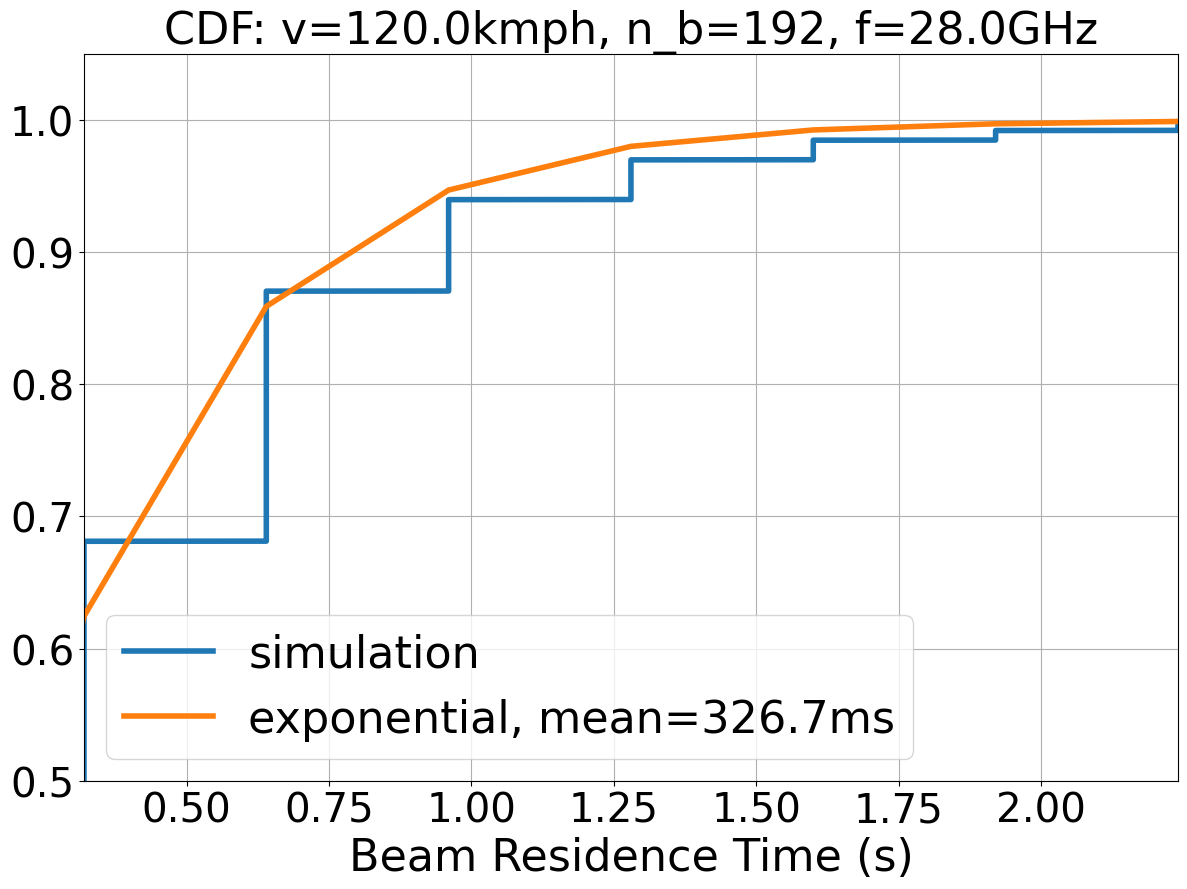

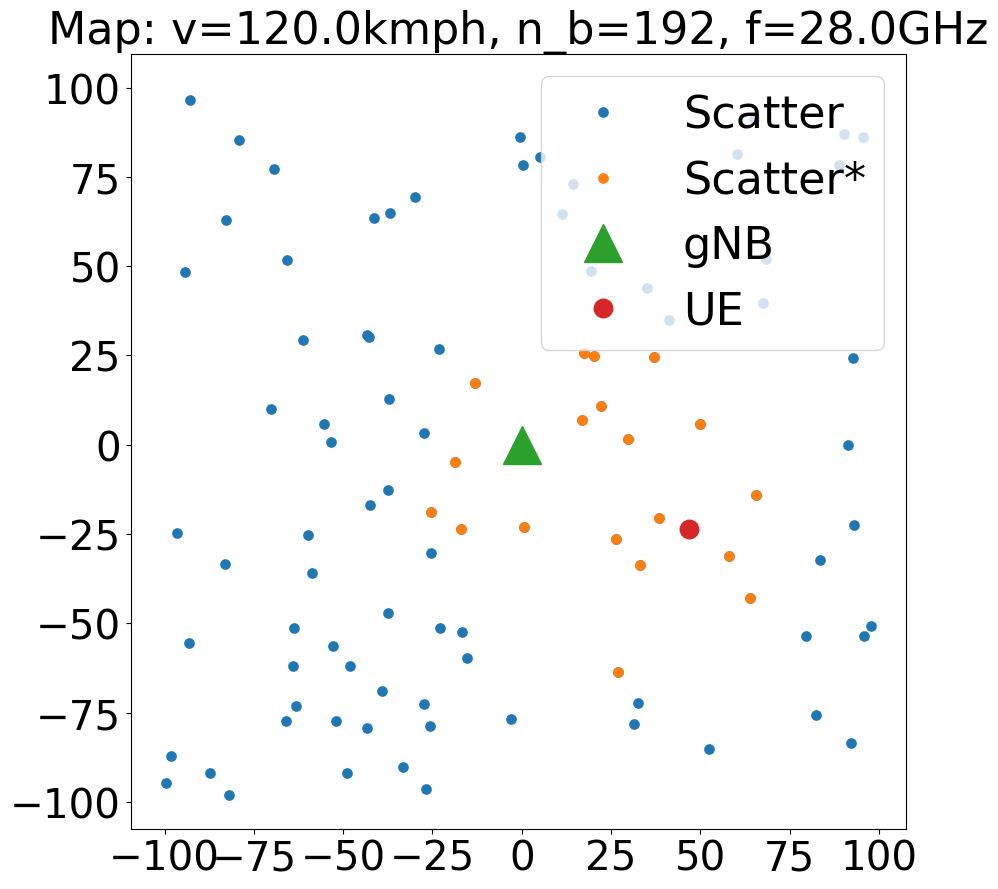

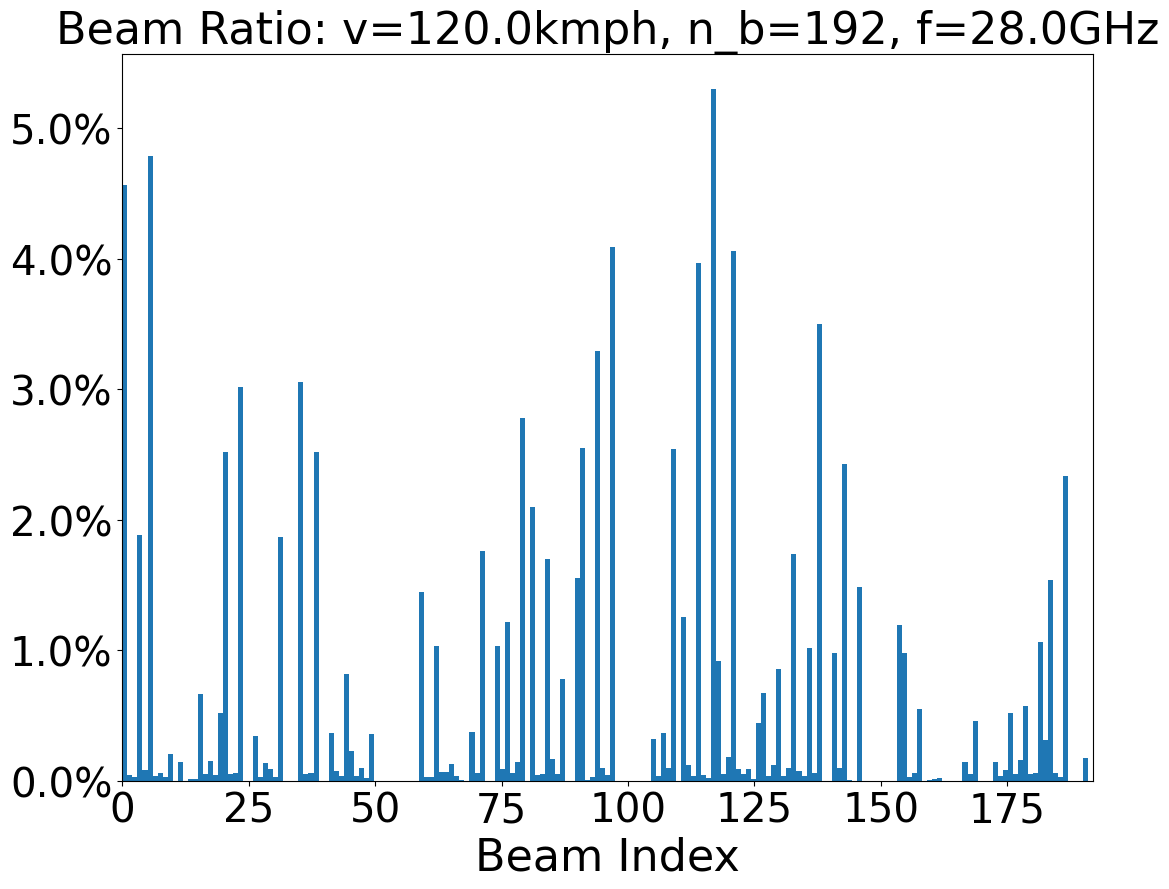

In [ ]:
import matplotlib.pyplot as plt

def download_plot(filename):
  rc('pdf', fonttype=42)
  plt.tight_layout()
  plt.savefig(filename+'.pdf')
  #files.download(filename+'.pdf')

data, li, ll = [], -1, 1
for i in bbest:
  if li == i:
    ll += 1
  else:
    li = i
    data.append(ll*dt)
    ll = 1
data = np.array(data)
eml = data.mean()

fsize=32

rcParams.update({'font.size': 14})
plt.style.use('default')
plt.figure(figsize=(12,9))
plt.plot(np.sort(data), np.arange(0,1,1/data.size), label='simulation', linewidth=fsize/8)
eml *= 0.65
plt.plot(np.arange(0, 10, dt), 1-np.exp(-np.arange(0, 10, dt)/eml), label='exponential, mean={}ms'.format(round(eml*1000,1)), linewidth=fsize/8)
plt.xlim(dt, np.sort(data)[int(data.size*0.995)])
plt.ylim(0.5, 1.05)
plt.legend(fontsize=fsize)
plt.title('CDF: v={}kmph, n_b={}, f={}GHz'.format(round(v*3.6/dt,1), nb*3, round(f*1e-9,1)), fontsize=fsize)
plt.xlabel('Beam Residence Time (s)', fontsize=fsize)
plt.xticks(fontsize=fsize/1.1)
plt.yticks(fontsize=fsize/1.1)
plt.grid()
download_plot('CDF_v={}kmph_n_b={}_f={}GHz'.format(round(v*3.6/dt,1), nb*3, round(f*1e-9,1)))

rcParams.update({'font.size': 14})
plt.style.use('default')
plt.figure(figsize=(12,9))
plt.plot(sp[:,0],sp[:,1],'.', label='Scatter', markersize=fsize/2.4)
plt.plot(sp[sl,0],sp[sl,1],'.', label='Scatter*', markersize=fsize/2.4)
plt.plot(0,0,'^', label='gNB', markersize=fsize/1.2)
plt.plot(p[0],p[1],'.', label='UE', markersize=fsize/1.2)
plt.axis('square')
plt.legend(fontsize=fsize)
plt.title('Map: v={}kmph, n_b={}, f={}GHz'.format(round(v*3.6/dt,1), nb*3, round(f*1e-9,1)), fontsize=fsize)
plt.xticks(fontsize=fsize/1.1)
plt.yticks(fontsize=fsize/1.1)
download_plot('Map_v={}kmph_n_b={}_f={}GHz'.format(round(v*3.6/dt,1), nb*3, round(f*1e-9,1)))

from matplotlib.ticker import PercentFormatter
rcParams.update({'font.size': 14})
plt.style.use('default')
plt.figure(figsize=(12,9))
plt.hist(bbest, nb*3, weights=np.ones(len(bbest)) / len(bbest))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.title('Beam Ratio: v={}kmph, n_b={}, f={}GHz'.format(round(v*3.6/dt,1), nb*3, round(f*1e-9,1)), fontsize=fsize)
plt.xlabel('Beam Index', fontsize=fsize)
plt.xticks(fontsize=fsize/1.1)
plt.yticks(fontsize=fsize/1.1)
plt.xlim(0, nb*3)
download_plot('Beam_Ratio_v={}kmph_n_b={}_f={}GHz'.format(round(v*3.6/dt,1), nb*3, round(f*1e-9,1)))